
# Stage 2 – Time Series Anomaly Detection on SMD (ServerMachineDataset)

This notebook implements **Stage 2 – Application of Data Mining Techniques** for a multivariate
time series anomaly detection project, using the **ServerMachineDataset (SMD)** from the
OmniAnomaly repository:

> https://github.com/NetManAIOps/OmniAnomaly/tree/master/ServerMachineDataset

We work with **one machine at a time** (e.g. `machine-1-1`), exactly as in your EDA code,
and we do **not** need to load the entire dataset into memory.

The pipeline is aligned with the KDD process:

1. **Data preparation**
   - Load SMD train / test files for one machine
   - Normalize features using training statistics
   - Build sliding windows (temporal context)
2. **Modeling**
   - Mean reconstruction baseline
   - LSTM autoencoder
   - Transformer-based autoencoder (TranAD-inspired, simplified)
3. **Evaluation**
   - Reconstruction-based anomaly scores
   - Thresholding via high-quantile on training errors
   - Precision, Recall, F1, ROC-AUC, PR-AUC (if labels are available)


# 1. **Setup & Configuration**

In [1]:

import os
from typing import Tuple, Optional, Dict
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
)

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Helper function for sinusoidal positional encoding
def sinusoidal_pos_encoding(max_len, d_model):
    position = torch.arange(max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe = torch.zeros(max_len, d_model)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe.unsqueeze(0) # (1, max_len, d_model)


Using device: cuda


# 2. **SMD Data Loading**<a id='data-loading'></a>

The original **SMD** structure (from the OmniAnomaly repo) is:

- `ServerMachineDataset/train/machine-x-y.txt` – training data (normal only)
- `ServerMachineDataset/test/machine-x-y.txt` – test data (with anomalies)
- `ServerMachineDataset/test_label/machine-x-y.txt` – test labels (0 = normal, 1 = anomaly)
- `ServerMachineDataset/interpretation_label/machine-x-y.txt` – detailed feature-level anomaly info

We define a loader that:

1. Reads the `train` and `test` `.txt` files for a single machine.
2. Optionally reads `test_label` if available to build a 0/1 label vector.
3. Returns NumPy arrays `(train_data, test_data, test_labels)`.


### 2.1 SMD Data Loading (single machine)

In [2]:
import os

# elenco macchine (dal README OmniAnomaly)
files = [f"machine-{i}-{j}.txt"
         for i, j in [(1,k) for k in range(1,9)] +
                      [(2,k) for k in range(1,10)] +
                      [(3,k) for k in range(1,10)]]

# --- TRAIN ---
base_url_train = "https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/train/"
os.makedirs("data/ServerMachineDataset/train", exist_ok=True)

for fname in files:
    url = base_url_train + fname
    out = f"data/ServerMachineDataset/train/{fname}"
    if not os.path.exists(out):
        print("Downloading train:", url)
        !wget -q {url} -O {out}

# --- TEST ---
base_url_test = "https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/test/"
os.makedirs("data/ServerMachineDataset/test", exist_ok=True)

for fname in files:
    url = base_url_test + fname
    out = f"data/ServerMachineDataset/test/{fname}"
    if not os.path.exists(out):
        print("Downloading test :", url)
        !wget -q {url} -O {out}

# --- TEST LABEL ---
base_url_label = "https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/test_label/"
os.makedirs("data/ServerMachineDataset/test_label", exist_ok=True)

for fname in files:
    url = base_url_label + fname
    out = f"data/ServerMachineDataset/test_label/{fname}"
    if not os.path.exists(out):
        print("Downloading label:", url)
        !wget -q {url} -O {out}

# --- INTERPRETATION LABEL (per feature-level diagnosis) ---
base_url_interp = "https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/interpretation_label/"
os.makedirs("data/ServerMachineDataset/interpretation_label", exist_ok=True)

for fname in files:
    url = base_url_interp + fname
    out = f"data/ServerMachineDataset/interpretation_label/{fname}"
    if not os.path.exists(out):
        print("Downloading interp:", url)
        !wget -q {url} -O {out}


In [3]:
from pathlib import Path

def load_smd_machine(
    train_dir: str,
    machine_id: str = "machine-1-1",
    test_dir: str = None,
    label_dir: str = None,
):
    """
    Load SMD data for a single machine, using the same folder structure
    you already used in your EDA notebook.

    Parameters
    ----------
    train_dir : str
        Folder that contains the training .txt files, e.g. "data/ServerMachineDataset/train".
    machine_id : str
        Machine identifier, e.g. "machine-1-1".
    test_dir : str, optional
        Folder that contains the test .txt files. If None, defaults to parent of train_dir / "test".
    label_dir : str, optional
        Folder that contains the test_label .txt files. If None, defaults to parent of train_dir / "test_label".

    Returns
    -------
    train_data : np.ndarray (T_train, D)
    test_data  : np.ndarray (T_test, D) or None if test file not found
    test_labels : np.ndarray (T_test,) or None if label file not found
    """
    train_dir = Path(train_dir)

    if test_dir is None:
        test_dir = train_dir.parent / "test"
    else:
        test_dir = Path(test_dir)

    if label_dir is None:
        label_dir = train_dir.parent / "test_label"
    else:
        label_dir = Path(label_dir)

    train_path = train_dir / f"{machine_id}.txt"
    test_path = test_dir / f"{machine_id}.txt"
    label_path = label_dir / f"{machine_id}.txt"

    if not train_path.exists():
        raise FileNotFoundError(f"Train file not found: {train_path}")

    train_df = pd.read_csv(train_path, header=None)
    train_data = train_df.values.astype(np.float32)

    print(f"Loaded SMD machine {machine_id}")
    print("Train shape:", train_data.shape)

    # Test may or may not exist
    if test_path.exists():
        test_df = pd.read_csv(test_path, header=None)
        test_data = test_df.values.astype(np.float32)
        print("Test  shape:", test_data.shape)
    else:
        print(f"⚠️ Test file not found: {test_path} – using None.")
        test_data = None

    # Labels may or may not exist
    if label_path.exists():
        labels_df = pd.read_csv(label_path, header=None)
        test_labels = labels_df.values.squeeze().astype(int)
        print("Labels shape:", test_labels.shape)
        print("Number of anomalous points in test:", int(test_labels.sum()))
    else:
        print(f"⚠️ Label file not found: {label_path} – using None.")
        test_labels = None

    return train_data, test_data, test_labels


### 2.2-3. **Preprocessing: Normalization & Sliding Windows**<a id='preprocessing'></a>

We now:

1. **Normalize** each feature using **min-max normalization** (based only on the training set):
   \[
   x_t' = \frac{x_t - \min(T)}{\max(T) - \min(T) + \epsilon}
   \]
2. **Create sliding windows** of length \(K\) for each time step, with *replication padding*
   at the beginning of the series.


In [4]:

def min_max_normalize(train: np.ndarray, test: np.ndarray, eps: float = 1e-8):
    '''
    Min-max normalization per feature, using only training data statistics.
    '''
    data_min = train.min(axis=0, keepdims=True)
    data_max = train.max(axis=0, keepdims=True)

    train_norm = (train - data_min) / (data_max - data_min + eps)
    test_norm = (test - data_min) / (data_max - data_min + eps)

    return train_norm.astype(np.float32), test_norm.astype(np.float32), data_min, data_max


def create_sliding_windows(
    data: np.ndarray, window_size: int
) -> np.ndarray:
    '''
    Create sliding windows of length K for each time step t, with replication padding.
    '''
    T, D = data.shape
    K = window_size
    windows = np.zeros((T, K, D), dtype=np.float32)

    for t in range(T):
        start = t - K + 1
        if start < 0:
            pad_len = -start
            windows[t, :pad_len, :] = data[0:1, :]
            windows[t, pad_len:, :] = data[0:t+1, :]
        else:
            windows[t] = data[start:t+1, :]

    return windows



### **PyTorch Dataset & DataLoaders**<a id='dataset'></a>


In [5]:

class TimeSeriesWindowDataset(Dataset):
    '''
    A simple dataset returning one window (K, D) at a time.
    '''
    def __init__(self, windows: np.ndarray):
        self.windows = windows

    def __len__(self):
        return self.windows.shape[0]

    def __getitem__(self, idx):
        x = self.windows[idx]
        return torch.from_numpy(x)


def create_dataloaders(
    train_windows: np.ndarray,
    batch_size: int = 128,
    val_ratio: float = 0.2,
):
    '''
    Split training windows into train/val (e.g., 80/20) and create DataLoaders.
    '''
    T = train_windows.shape[0]
    val_len = int(T * val_ratio)
    train_len = T - val_len

    train_w = train_windows[:train_len]
    val_w = train_windows[train_len:]

    train_ds = TimeSeriesWindowDataset(train_w)
    val_ds = TimeSeriesWindowDataset(val_w)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

    return train_loader, val_loader


# 3. Baseline Models &  **Models Definition**
We define three models of increasing complexity:

In [6]:

class MeanReconstructionBaseline(nn.Module):
    '''
    Baseline: reconstruct each window as its feature-wise mean along the time dimension.
    '''
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # x: (B, K, D)
        mean = x.mean(dim=1, keepdim=True)  # (B, 1, D)
        return mean.repeat(1, x.shape[1], 1)


## 3.1 LSTM Autoencoder

In [7]:

class LSTMAutoencoder(nn.Module):
    '''
    LSTM-based autoencoder for sequence reconstruction.
    '''
    def __init__(self, input_dim: int, hidden_dim: int = 64, latent_dim: int = 32, num_layers: int = 1):
        super().__init__()
        self.encoder = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers, batch_first=True
        )
        self.enc_to_latent = nn.Linear(hidden_dim, latent_dim)

        self.latent_to_dec = nn.Linear(latent_dim, hidden_dim)
        self.decoder = nn.LSTM(
            hidden_dim, input_dim, num_layers=num_layers, batch_first=True
        )

    def forward(self, x):
        # x: (B, K, D)
        enc_out, _ = self.encoder(x)          # enc_out: (B, K, H)
        h_last = enc_out[:, -1, :]            # last hidden state (B, H)
        z = self.enc_to_latent(h_last)        # (B, latent)

        # Decoder: repeat latent over K time steps
        dec_init = self.latent_to_dec(z).unsqueeze(1)  # (B,1,H)
        K = x.shape[1]
        dec_input = dec_init.repeat(1, K, 1)           # (B,K,H)

        dec_out, _ = self.decoder(dec_input)           # (B,K,D)
        return dec_out


## 3.2 Transformer AE (reference, MSE)

In [8]:

class TransformerAEPlain(nn.Module):
    '''
    Simplified Transformer-based autoencoder (TranAD-inspired).
    '''
    def __init__(
        self,
        input_dim: int,
        d_model: int = 64,
        nhead: int = 4,
        num_layers: int = 1,
        dim_feedforward: int = 128,
        dropout: float = 0.1,
        max_len: int = 512,
    ):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model

        self.input_projection = nn.Linear(input_dim, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.output_projection = nn.Linear(d_model, input_dim)

        # Learnable positional embeddings
        self.pos_embedding = nn.Embedding(max_len, d_model)

    def forward(self, x):
        # x: (B, K, D)
        B, K, D = x.shape
        pos_ids = torch.arange(0, K, device=x.device).unsqueeze(0).repeat(B, 1)  # (B,K)

        x_proj = self.input_projection(x) + self.pos_embedding(pos_ids)         # (B,K,d_model)

        memory = self.encoder(x_proj)                                           # (B,K,d_model)
        out = self.decoder(tgt=x_proj, memory=memory)                           # (B,K,d_model)
        recon = self.output_projection(out)                                     # (B,K,D)
        return recon


## 3.3 Transformer AE (LN + Huber)
Key differences.
Our LayerNorm-based transformer differs from the plain version in three main aspects:

1. It uses a learnable positional embedding of shape
1×𝐾×𝑑 model 1×K×d model (with K=10 in our experiments), instead of a large fixed embedding table.

2. We enable norm_first=True, so Layer Normalisation is applied before the self-attention and feed-forward blocks, which stabilises the internal activations.

3. We add a final LayerNorm (final_norm) on the decoder output, which further stabilises the reconstructed time series.

These changes make the transformer much more numerically stable, significantly reducing extreme reconstruction errors while preserving overall reconstruction quality.

In [9]:
##version corrected
import torch
import torch.nn as nn

class TransformerAELN(nn.Module):
    def __init__(self, input_dim=38, d_model=64, nhead=4, num_layers=1):
        super().__init__()

        # === Input projection ===
        self.input_proj = nn.Linear(input_dim, d_model)

        # === Learned positional embeddings ===
        self.pos_embedding = nn.Parameter(torch.randn(1, 10, d_model))

        # === Encoder (with LayerNorm) ===
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=0.1,
            norm_first=True   # <-- IMPORTANT
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # === Decoder (with LayerNorm) ===
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=0.1,
            norm_first=True   # <-- IMPORTANT
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # === Output projection ===
        self.output_proj = nn.Linear(d_model, input_dim)

        # === Final normalization (helps stability) ===
        self.final_norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        # x: (batch, seq, features)

        # Input → latent
        x = self.input_proj(x) + self.pos_embedding

        # Encode
        z = self.encoder(x)

        # Decode using encoded representation as memory
        out = self.decoder(tgt=x, memory=z)

        # Output projection + final stability norm
        out = self.output_proj(out)
        out = self.final_norm(out)

        return out


# 4. Training Results

In [10]:

def train_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: Optional[torch.optim.Optimizer],
    criterion: nn.Module,
    train_mode: bool = True,
) -> float:
    '''
    Run one training or validation epoch.
    '''
    model.train(train_mode)
    total_loss = 0.0
    n_samples = 0

    for batch in dataloader:
        x = batch.to(device).float()
        recon = model(x)
        loss = criterion(recon, x)

        if train_mode and optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        n_samples += x.size(0)

    return total_loss / n_samples


def fit_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 20,
    lr: float = 1e-3,
    weight_decay: float = 1e-5,
) -> Dict[str, list]:
    '''
    Full training loop for an autoencoder-style model.
    '''
    model.to(device)

    if any(p.requires_grad for p in model.parameters()):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = None

    criterion = nn.MSELoss()
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            criterion,
            train_mode=(optimizer is not None),
        )
        val_loss = train_epoch(
            model,
            val_loader,
            optimizer=None,
            criterion=criterion,
            train_mode=False,
        )

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(
            f"Epoch {epoch:03d} | train_loss={train_loss:.6f} | val_loss={val_loss:.6f}"
        )

    return history


## 4.1 **Huber fit model** for 8.6.2

In [11]:
import torch.nn as nn

def fit_model_huber(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 40,
    lr: float = 1e-3,
    weight_decay: float = 1e-5,
    delta: float = 1.0,   # parametro di Huber
) -> Dict[str, list]:
    """
    Training loop using SmoothL1Loss (Huber loss) for robustness.
    """
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.SmoothL1Loss()   # Huber

    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, train_mode=True)
        val_loss   = train_epoch(model, val_loader,   optimizer=None,   criterion=criterion, train_mode=False)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(f"[Huber] Epoch {epoch:03d} | train_loss={train_loss:.6f} | val_loss={val_loss:.6f}")

    return history

## 4.2 **Position encoding traformer** for 8.6.4

In [12]:
#function needed to define de positional encoding

def sinusoidal_pos_encoding(max_len: int, d_model: int, device=None):
    """
    Classic sinusoidal positional encoding (Vaswani et al.).
    Returns tensor of shape (1, max_len, d_model).
    """
    if device is None:
        device = torch.device("cpu")

    pe = torch.zeros(max_len, d_model, device=device)
    position = torch.arange(0, max_len, dtype=torch.float, device=device).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2, device=device).float() * (-np.log(10000.0) / d_model))

    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    pe = pe.unsqueeze(0)  # (1, max_len, d_model)
    return pe


## 4.3 **Positional Encoding Trasformer**

In [13]:
class TransformerAEMixedPos(nn.Module):
    """
    Transformer AE with LayerNorm and mixed positional encoding
    (learnable + sinusoidal).
    """
    def __init__(self, input_dim=38, d_model=64, nhead=4, num_layers=1, max_len=10):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)

        self.pos_learned = nn.Parameter(torch.randn(1, max_len, d_model))
        self.register_buffer("pos_sinusoidal", sinusoidal_pos_encoding(max_len, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=0.1,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=0.1,
            norm_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(d_model, input_dim)
        self.final_norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        # x: (B, K, D), K <= max_len
        B, K, _ = x.shape
        pos_learned = self.pos_learned[:, :K, :]
        pos_sinus   = self.pos_sinusoidal[:, :K, :]
        pos = pos_learned + pos_sinus

        x = self.input_proj(x) + pos
        z = self.encoder(x)
        out = self.decoder(tgt=x, memory=z)
        out = self.output_proj(out)
        out = self.final_norm(out)
        return out



# 5. **Anomaly Scoring & Evaluation Metrics**


## 5.1 Feature-level (dimension-wise) anomaly diagnosis

In addition to a single anomaly score per timestamp, we can also analyze **which dimensions**
(features) contribute most to the reconstruction error.

We do this by:
- Computing the **MSE per feature** (averaged over the window length).
- Learning a **separate threshold per feature** from the training set.
- Producing a **multi-label prediction** matrix of shape `(T, D)` where each entry
  indicates whether a given feature is anomalous at a given time step.


In [14]:

def compute_feature_level_errors(
    model: nn.Module,
    windows: np.ndarray,
) -> np.ndarray:
    '''
    Compute reconstruction errors per feature (dimension) for each window/time step.

    Parameters
    ----------
    model : nn.Module
        Trained reconstruction model (e.g. LSTMAutoencoder, TransformerAutoencoder).
    windows : np.ndarray
        Sliding windows of shape (T, K, D).

    Returns
    -------
    feature_errors : np.ndarray
        Array of shape (T, D), where each entry [t, d] is the average MSE for
        feature d over the K positions in the window ending at time t.
    '''
    model.to(device)
    model.eval()

    ds = TimeSeriesWindowDataset(windows)
    loader = DataLoader(ds, batch_size=256, shuffle=False, drop_last=False)

    all_feat_errors = []
    criterion = nn.MSELoss(reduction="none")

    with torch.no_grad():
        for batch in loader:
            x = batch.to(device).float()           # (B,K,D)
            recon = model(x)
            loss_per_element = criterion(recon, x) # (B,K,D)
            # average over time dimension K, keep feature dimension D
            loss_per_feature = loss_per_element.mean(dim=1)  # (B,D)
            all_feat_errors.append(loss_per_feature.cpu().numpy())

    feature_errors = np.concatenate(all_feat_errors, axis=0)  # (T,D)
    return feature_errors


def choose_feature_thresholds(
    train_feature_errors: np.ndarray,
    quantile: float = 0.995,
) -> np.ndarray:
    '''
    Choose a separate threshold for each feature based on training feature-level errors.

    Parameters
    ----------
    train_feature_errors : np.ndarray
        Array of shape (T_train, D) with feature-wise errors.
    quantile : float
        High quantile used as threshold per feature.

    Returns
    -------
    thresholds : np.ndarray
        Array of shape (D,) with one threshold per feature.
    '''
    # quantile along time (axis=0), for each feature
    thresholds = np.quantile(train_feature_errors, quantile, axis=0)
    return thresholds.astype(np.float32)


def compute_feature_level_predictions(
    feature_errors: np.ndarray,
    thresholds: np.ndarray,
) -> np.ndarray:
    '''
    Multi-label (dimension-wise) anomaly predictions.

    Parameters
    ----------
    feature_errors : np.ndarray
        Array of shape (T, D) with feature-wise anomaly scores.
    thresholds : np.ndarray
        Array of shape (D,) with thresholds per feature.

    Returns
    -------
    y_pred_feat : np.ndarray
        Binary matrix of shape (T, D), where y_pred_feat[t, d] = 1 if feature d
        is anomalous at time t.
    '''
    # Broadcast thresholds over time dimension
    return (feature_errors >= thresholds[np.newaxis, :]).astype(int)


## 5.2 Compute reconstruction errors

In [15]:

def compute_reconstruction_errors(
    model: nn.Module,
    windows: np.ndarray,
) -> np.ndarray:
    '''
    Compute reconstruction errors (MSE) per window/time step.
    '''
    model.to(device)
    model.eval()

    ds = TimeSeriesWindowDataset(windows)
    loader = DataLoader(ds, batch_size=256, shuffle=False, drop_last=False)

    all_errors = []
    criterion = nn.MSELoss(reduction="none")

    with torch.no_grad():
        for batch in loader:
            x = batch.to(device).float()
            recon = model(x)
            loss_per_element = criterion(recon, x)      # (B,K,D)
            loss_per_window = loss_per_element.mean(dim=(1, 2))  # (B,)
            all_errors.append(loss_per_window.cpu().numpy())

    errors = np.concatenate(all_errors, axis=0)
    return errors


def choose_threshold(errors: np.ndarray, quantile: float = 0.995) -> float:
    '''
    Choose a high-quantile threshold from training reconstruction errors.
    '''
    return np.quantile(errors, quantile)


def compute_predictions(errors: np.ndarray, threshold: float) -> np.ndarray:
    '''
    Map anomaly scores to binary predictions via threshold.
    '''
    return (errors >= threshold).astype(int)


def evaluate_anomaly_detection(
    y_true: np.ndarray,
    scores: np.ndarray,
    y_pred: np.ndarray,
) -> Dict[str, float]:
    '''
    Compute Precision, Recall, F1, ROC-AUC, and PR-AUC.
    '''
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )

    try:
        auc_roc = roc_auc_score(y_true, scores)
    except ValueError:
        auc_roc = float("nan")

    try:
        auc_pr = average_precision_score(y_true, scores)
    except ValueError:
        auc_pr = float("nan")

    return {
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "auc_roc": float(auc_roc),
        "auc_pr": float(auc_pr),
    }


# 6. **End-to-End Experiment Pipeline on One SMD Machine**

In this final section you can:

- Select the **SMD root** and a **machine_id** (e.g. `machine-1-1`).
- Run the full Stage-2 pipeline for that machine.

In [16]:
import os

# Path to the root of the ServerMachineDataset (parent of 'train', 'test', 'test_label')
# This path now assumes the data was downloaded to the local Colab filesystem by a previous cell.
SMD_ROOT = "data/ServerMachineDataset" # Adjusted to reflect downloaded data location
SMD_TRAIN_DIR = os.path.join(SMD_ROOT, "train")
MACHINE_ID = "machine-1-1"  # or the machine you have chosen

WINDOW_SIZE = 10
BATCH_SIZE = 128
EPOCHS = 20

print("SMD_ROOT:", SMD_ROOT)
print("SMD_TRAIN_DIR:", SMD_TRAIN_DIR)
print("MACHINE_ID:", MACHINE_ID)


SMD_ROOT: data/ServerMachineDataset
SMD_TRAIN_DIR: data/ServerMachineDataset/train
MACHINE_ID: machine-1-1


## 6.1 Load and normalise data

Loaded SMD machine machine-1-1
Train shape: (28479, 38)
Test  shape: (28479, 38)
Labels shape: (28479,)
Number of anomalous points in test: 2694
train_norm: (28479, 38)
test_norm : (28479, 38)


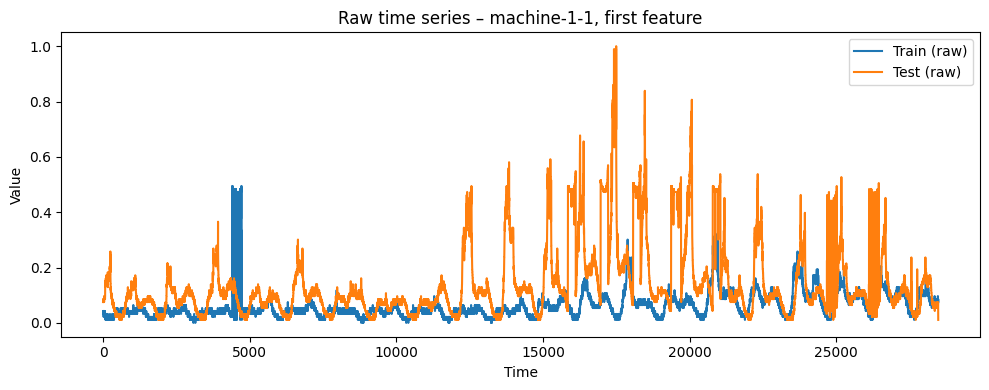

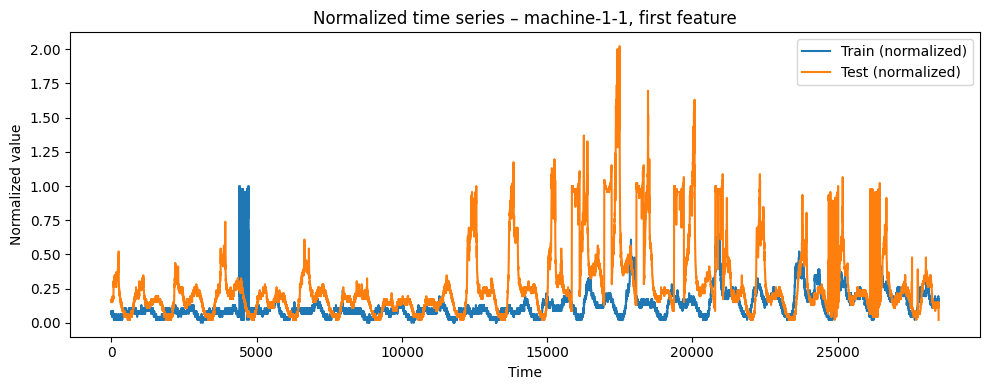

In [17]:

# ==== 8.2 Load & Normalize Data ====

from pathlib import Path

# Use the SMD_TRAIN_DIR defined in the previous section, which correctly points to the 'train' subdirectory
train_data, test_data, test_labels = load_smd_machine(SMD_TRAIN_DIR, MACHINE_ID)

# Normalize using training statistics
train_norm, test_norm, data_min, data_max = min_max_normalize(train_data, test_data)

print("train_norm:", train_norm.shape)
print("test_norm :", test_norm.shape)

# Quick sanity check on first feature
plt.figure(figsize=(10, 4))
plt.plot(train_data[:, 0], label="Train (raw)")
plt.plot(test_data[:, 0], label="Test (raw)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title(f"Raw time series – {MACHINE_ID}, first feature")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(train_norm[:, 0], label="Train (normalized)")
plt.plot(test_norm[:, 0], label="Test (normalized)")
plt.xlabel("Time")
plt.ylabel("Normalized value")
plt.title(f"Normalized time series – {MACHINE_ID}, first feature")
plt.legend()
plt.tight_layout()
plt.show()


## 6.2 Creating sliding windows

In [18]:

# ==== 8.3 Create Sliding Windows & DataLoaders ====

train_windows = create_sliding_windows(train_norm, WINDOW_SIZE)
test_windows = create_sliding_windows(test_norm, WINDOW_SIZE)

print("Train windows shape:", train_windows.shape)
print("Test  windows shape:", test_windows.shape)

train_loader, val_loader = create_dataloaders(
    train_windows, batch_size=BATCH_SIZE, val_ratio=0.2
)

input_dim = train_data.shape[1]
print("Input dimension (features):", input_dim)


Train windows shape: (28479, 10, 38)
Test  windows shape: (28479, 10, 38)
Input dimension (features): 38


## 6.3 Mean reconstruction baseline

In [19]:

# ==== 8.4 Mean Reconstruction Baseline ====

print("\n=== Mean Reconstruction Baseline ===")
mean_model = MeanReconstructionBaseline()
_ = fit_model(mean_model, train_loader, val_loader, num_epochs=1)

train_errors_mean = compute_reconstruction_errors(mean_model, train_windows)
test_errors_mean = compute_reconstruction_errors(mean_model, test_windows)

# quick sanity check on error scale
test_scores = test_errors_mean # Corrected: use test_errors_mean for the Mean Baseline
print("Huge values:", np.sum(test_scores > 10))
print("min / max:", test_scores.min(), test_scores.max())

if test_labels is not None:
    thr_mean = choose_threshold(train_errors_mean, quantile=0.995)
    y_pred_mean = compute_predictions(test_errors_mean, thr_mean)
    metrics_mean = evaluate_anomaly_detection(test_labels, test_errors_mean, y_pred_mean)
    print("Mean baseline metrics:", metrics_mean)
else:
    print("No labels available: skipping metric computation for baseline.")



=== Mean Reconstruction Baseline ===
Epoch 001 | train_loss=0.000665 | val_loss=0.000736
Huge values: 480
min / max: 2.2350545e-16 73592080000000.0
Mean baseline metrics: {'precision': 0.5684257602862254, 'recall': 0.4717891610987379, 'f1': 0.5156186612576065, 'auc_roc': 0.9105175730035315, 'auc_pr': 0.5767005550490444}


## 6.4 LSTM Autoencoder

In [20]:

# ==== 8.5 LSTM Autoencoder ====

print("\n=== LSTM Autoencoder ===")
lstm_model = LSTMAutoencoder(input_dim=input_dim, hidden_dim=64, latent_dim=32)
hist_lstm = fit_model(lstm_model, train_loader, val_loader, num_epochs=EPOCHS, lr=1e-3)

train_errors_lstm = compute_reconstruction_errors(lstm_model, train_windows)
test_errors_lstm = compute_reconstruction_errors(lstm_model, test_windows)

# quick sanity check on error scale
test_scores = test_errors_lstm # Corrected: use test_errors_lstm for the LSTM Autoencoder
print("Huge values:", np.sum(test_scores > 10))
print("min / max:", test_scores.min(), test_scores.max())

if test_labels is not None:
    thr_lstm = choose_threshold(train_errors_lstm, quantile=0.995)
    y_pred_lstm = compute_predictions(test_errors_lstm, thr_lstm)
    metrics_lstm = evaluate_anomaly_detection(test_labels, test_errors_lstm, y_pred_lstm)
    print("LSTM metrics:", metrics_lstm)
else:
    print("No labels available: skipping metric computation for LSTM.")



=== LSTM Autoencoder ===
Epoch 001 | train_loss=0.010115 | val_loss=0.002465
Epoch 002 | train_loss=0.002010 | val_loss=0.001854
Epoch 003 | train_loss=0.001383 | val_loss=0.001613
Epoch 004 | train_loss=0.001245 | val_loss=0.001526
Epoch 005 | train_loss=0.001197 | val_loss=0.001517
Epoch 006 | train_loss=0.001151 | val_loss=0.001475
Epoch 007 | train_loss=0.001104 | val_loss=0.001432
Epoch 008 | train_loss=0.001068 | val_loss=0.001427
Epoch 009 | train_loss=0.001042 | val_loss=0.001344
Epoch 010 | train_loss=0.001026 | val_loss=0.001349
Epoch 011 | train_loss=0.001019 | val_loss=0.001402
Epoch 012 | train_loss=0.001005 | val_loss=0.001341
Epoch 013 | train_loss=0.001003 | val_loss=0.001373
Epoch 014 | train_loss=0.000993 | val_loss=0.001302
Epoch 015 | train_loss=0.000987 | val_loss=0.001335
Epoch 016 | train_loss=0.000980 | val_loss=0.001303
Epoch 017 | train_loss=0.000978 | val_loss=0.001287
Epoch 018 | train_loss=0.000973 | val_loss=0.001330
Epoch 019 | train_loss=0.000968 | val_

## 6.5 Transformer AE variants

### Description of LSTM Model Metrics

The LSTM model's performance in anomaly detection is typically evaluated using several key metrics that assess its ability to correctly identify anomalous data points while minimizing false alarms. For this project, the following metrics are used:

-   **Precision**: Precision measures the proportion of correctly identified anomalous points among all points predicted as anomalous. A high precision indicates a low rate of false positives (i.e., normal points incorrectly flagged as anomalies). In anomaly detection, this is crucial when the cost of false alarms is high.

    $\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$

-   **Recall**: Recall (also known as Sensitivity) measures the proportion of correctly identified anomalous points among all actual anomalous points. A high recall indicates a low rate of false negatives (i.e., actual anomalies missed by the model). In anomaly detection, this is critical when the cost of missing an anomaly is high.

    $\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$

-   **F1-score**: The F1-score is the harmonic mean of Precision and Recall. It provides a single metric that balances both concerns. A high F1-score indicates that the model has good balance between precision and recall.

    $\text{F1-score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$

-   **ROC-AUC (Receiver Operating Characteristic - Area Under the Curve)**: ROC-AUC evaluates the model's ability to distinguish between normal and anomalous classes across various threshold settings. An AUC-ROC score closer to 1.0 indicates a better ability to separate the classes. It's robust to imbalanced datasets.

-   **PR-AUC (Precision-Recall - Area Under the Curve)**: PR-AUC is particularly useful for highly imbalanced datasets, which are common in anomaly detection (where anomalies are rare). It focuses on the positive class (anomalies) and provides a more informative measure than ROC-AUC when the number of true negatives is overwhelmingly large. A higher PR-AUC indicates better performance for detecting the rare class.

These metrics collectively offer a comprehensive view of how well the LSTM autoencoder detects anomalies based on reconstruction errors.

In [21]:

# ==== 8.6 Transformer Autoencoder ====

print("\n=== Transformer Autoencoder (with LayerNorm) ===")
transf_model = TransformerAELN(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1
)

hist_transf = fit_model(transf_model, train_loader, val_loader, num_epochs=EPOCHS, lr=1e-3)

train_errors_transf = compute_reconstruction_errors(transf_model, train_windows)
test_errors_transf  = compute_reconstruction_errors(transf_model,  test_windows)

# quick sanity check on error scale
test_scores = test_errors_transf
print("Huge values:", np.sum(test_scores > 10))
print("min / max:", test_scores.min(), test_scores.max())

if test_labels is not None:
    thr_transf = choose_threshold(train_errors_transf, quantile=0.995)
    y_pred_transf = compute_predictions(test_errors_transf, thr_transf)
    metrics_transf = evaluate_anomaly_detection(test_labels, test_errors_transf, y_pred_transf)
    print("Transformer metrics:", metrics_transf)
else:
    print("No labels available: skipping metric computation for Transformer.")



=== Transformer Autoencoder (with LayerNorm) ===


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.481235 | val_loss=0.287920
Epoch 002 | train_loss=0.161143 | val_loss=0.056102
Epoch 003 | train_loss=0.021045 | val_loss=0.012740
Epoch 004 | train_loss=0.005147 | val_loss=0.009250
Epoch 005 | train_loss=0.004025 | val_loss=0.008241
Epoch 006 | train_loss=0.003665 | val_loss=0.007515
Epoch 007 | train_loss=0.003245 | val_loss=0.006880
Epoch 008 | train_loss=0.002894 | val_loss=0.006481
Epoch 009 | train_loss=0.002643 | val_loss=0.006106
Epoch 010 | train_loss=0.002454 | val_loss=0.005875
Epoch 011 | train_loss=0.002299 | val_loss=0.005613
Epoch 012 | train_loss=0.002150 | val_loss=0.005274
Epoch 013 | train_loss=0.001973 | val_loss=0.004830
Epoch 014 | train_loss=0.001668 | val_loss=0.003820
Epoch 015 | train_loss=0.001101 | val_loss=0.002452
Epoch 016 | train_loss=0.000857 | val_loss=0.001784
Epoch 017 | train_loss=0.000767 | val_loss=0.001436
Epoch 018 | train_loss=0.000695 | val_loss=0.001221
Epoch 019 | train_loss=0.000607 | val_loss=0.001030
Epoch 020 | 

### **Trasformer with more dropout** for 8.6.3

In [22]:
class TransformerAELNDrop(nn.Module):
    """
    Transformer autoencoder with LayerNorm and higher dropout.
    """
    def __init__(self, input_dim=38, d_model=64, nhead=4, num_layers=1, dropout=0.3):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, 10, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=dropout,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=dropout,
            norm_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(d_model, input_dim)
        self.final_norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        x = self.input_proj(x) + self.pos_embedding
        z = self.encoder(x)
        out = self.decoder(tgt=x, memory=z)
        out = self.output_proj(out)
        out = self.final_norm(out)
        return out


### 6.5.1 Transformer AE (LayerNorms, 40 epochs)

In [23]:
# ==== 8.6.1 Transformer (LayerNorm) – more epochs ====

EPOCHS_TRANSF_LONG = 40

transf_model_long = TransformerAELN(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1
)

hist_transf_long = fit_model(
    transf_model_long,
    train_loader,
    val_loader,
    num_epochs=EPOCHS_TRANSF_LONG,
    lr=1e-3
)

train_errors_transf_long = compute_reconstruction_errors(transf_model_long, train_windows)
test_errors_transf_long  = compute_reconstruction_errors(transf_model_long, test_windows)

# sanity check
print("[Transf-long] Huge values:", np.sum(test_errors_transf_long > 10))
print("[Transf-long] min / max:", test_errors_transf_long.min(), test_errors_transf_long.max())

if test_labels is not None:
    thr_transf_long    = choose_threshold(train_errors_transf_long, quantile=0.995)
    y_pred_transf_long = compute_predictions(test_errors_transf_long, thr_transf_long)
    metrics_transf_long = evaluate_anomaly_detection(test_labels, test_errors_transf_long, y_pred_transf_long)
    print("Transformer (40 epochs) metrics:", metrics_transf_long)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.480456 | val_loss=0.289287
Epoch 002 | train_loss=0.164796 | val_loss=0.065729
Epoch 003 | train_loss=0.025030 | val_loss=0.013402
Epoch 004 | train_loss=0.005618 | val_loss=0.008265
Epoch 005 | train_loss=0.004249 | val_loss=0.007535
Epoch 006 | train_loss=0.003899 | val_loss=0.007074
Epoch 007 | train_loss=0.003539 | val_loss=0.006541
Epoch 008 | train_loss=0.003187 | val_loss=0.005946
Epoch 009 | train_loss=0.002872 | val_loss=0.005349
Epoch 010 | train_loss=0.002482 | val_loss=0.004403
Epoch 011 | train_loss=0.001557 | val_loss=0.002617
Epoch 012 | train_loss=0.001086 | val_loss=0.001978
Epoch 013 | train_loss=0.000961 | val_loss=0.001667
Epoch 014 | train_loss=0.000902 | val_loss=0.001495
Epoch 015 | train_loss=0.000866 | val_loss=0.001414
Epoch 016 | train_loss=0.000836 | val_loss=0.001345
Epoch 017 | train_loss=0.000810 | val_loss=0.001336
Epoch 018 | train_loss=0.000780 | val_loss=0.001243
Epoch 019 | train_loss=0.000744 | val_loss=0.001156
Epoch 020 | 

In [24]:
print("hist_lstm  in globals?  ", 'hist_lstm' in globals())
print("hist_transf in globals? ", 'hist_transf' in globals())
print("lstm_model in globals? ", 'lstm_model' in globals())
print("transf_model in globals?", 'transf_model' in globals())


hist_lstm  in globals?   True
hist_transf in globals?  True
lstm_model in globals?  True
transf_model in globals? True


### 6.5.2 Transformer AE (LN + Huber)

In [25]:

transf_model_huber = TransformerAELN(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1
)

hist_transf_huber = fit_model_huber(
    transf_model_huber,
    train_loader,
    val_loader,
    num_epochs=EPOCHS,   # es. 20
    lr=1e-3
)

train_errors_transf_huber = compute_reconstruction_errors(transf_model_huber, train_windows)
test_errors_transf_huber  = compute_reconstruction_errors(transf_model_huber,  test_windows)

print("[Transf-huber] Huge values:", np.sum(test_errors_transf_huber > 10))
print("[Transf-huber] min / max:", test_errors_transf_huber.min(), test_errors_transf_huber.max())

if test_labels is not None:
    thr_transf_huber    = choose_threshold(train_errors_transf_huber, quantile=0.995)
    y_pred_transf_huber = compute_predictions(test_errors_transf_huber, thr_transf_huber)
    metrics_transf_huber = evaluate_anomaly_detection(test_labels, test_errors_transf_huber, y_pred_transf_huber)
    print("Transformer (Huber) metrics:", metrics_transf_huber)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


[Huber] Epoch 001 | train_loss=0.143345 | val_loss=0.108544
[Huber] Epoch 002 | train_loss=0.077482 | val_loss=0.059129
[Huber] Epoch 003 | train_loss=0.038462 | val_loss=0.021952
[Huber] Epoch 004 | train_loss=0.009343 | val_loss=0.004929
[Huber] Epoch 005 | train_loss=0.002411 | val_loss=0.003461
[Huber] Epoch 006 | train_loss=0.001693 | val_loss=0.003086
[Huber] Epoch 007 | train_loss=0.001402 | val_loss=0.002765
[Huber] Epoch 008 | train_loss=0.001190 | val_loss=0.002439
[Huber] Epoch 009 | train_loss=0.001031 | val_loss=0.002098
[Huber] Epoch 010 | train_loss=0.000890 | val_loss=0.001813
[Huber] Epoch 011 | train_loss=0.000765 | val_loss=0.001579
[Huber] Epoch 012 | train_loss=0.000656 | val_loss=0.001375
[Huber] Epoch 013 | train_loss=0.000537 | val_loss=0.001058
[Huber] Epoch 014 | train_loss=0.000333 | val_loss=0.000598
[Huber] Epoch 015 | train_loss=0.000225 | val_loss=0.000454
[Huber] Epoch 016 | train_loss=0.000195 | val_loss=0.000373
[Huber] Epoch 017 | train_loss=0.000165 

### 6.5.3 Transformer AE (extra dropout)

In [26]:

# ==== 8.6.3 Transformer Autoencoder with more dropout ====

print("\n=== Transformer Autoencoder (with LayerNorm & higher dropout) ===")
transf_model_drop = TransformerAELNDrop(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1
)

hist_transf_drop = fit_model(
    transf_model_drop,
    train_loader,
    val_loader,
    num_epochs=EPOCHS,
    lr=1e-3
)

train_errors_transf_drop = compute_reconstruction_errors(transf_model_drop, train_windows)
test_errors_transf_drop  = compute_reconstruction_errors(transf_model_drop, test_windows)

# sanity check
test_scores = test_errors_transf_drop
print("Huge values:", np.sum(test_scores > 10))
print("min / max:", test_scores.min(), test_scores.max())

if test_labels is not None:
    thr_transf_drop = choose_threshold(train_errors_transf_drop, quantile=0.995)
    y_pred_transf_drop = compute_predictions(test_errors_transf_drop, thr_transf_drop)
    metrics_transf_drop = evaluate_anomaly_detection(test_labels, test_errors_transf_drop, y_pred_transf_drop)
    print("Transformer (Dropout) metrics:", metrics_transf_drop)
else:
    print("No labels available: skipping metric computation for Transformer.")



=== Transformer Autoencoder (with LayerNorm & higher dropout) ===


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.484305 | val_loss=0.290382
Epoch 002 | train_loss=0.166859 | val_loss=0.066542
Epoch 003 | train_loss=0.026364 | val_loss=0.015410
Epoch 004 | train_loss=0.006434 | val_loss=0.010107
Epoch 005 | train_loss=0.004823 | val_loss=0.009168
Epoch 006 | train_loss=0.004387 | val_loss=0.008705
Epoch 007 | train_loss=0.004005 | val_loss=0.008225
Epoch 008 | train_loss=0.003622 | val_loss=0.007832
Epoch 009 | train_loss=0.003378 | val_loss=0.007519
Epoch 010 | train_loss=0.003181 | val_loss=0.007167
Epoch 011 | train_loss=0.003029 | val_loss=0.006857
Epoch 012 | train_loss=0.002900 | val_loss=0.006489
Epoch 013 | train_loss=0.002773 | val_loss=0.006097
Epoch 014 | train_loss=0.002613 | val_loss=0.005410
Epoch 015 | train_loss=0.002361 | val_loss=0.004484
Epoch 016 | train_loss=0.002023 | val_loss=0.003607
Epoch 017 | train_loss=0.001461 | val_loss=0.001801
Epoch 018 | train_loss=0.000687 | val_loss=0.000989
Epoch 019 | train_loss=0.000521 | val_loss=0.000719
Epoch 020 | 

### 6.5.4 Transformer AE (LN + mixed positional encoding)

In [27]:

print("\n=== Transformer Autoencoder (LayerNorm + mixed positional encoding) ===")
transf_model_mixed = TransformerAEMixedPos(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1,
    max_len=WINDOW_SIZE # Corrected: Changed 'K' to 'max_len'
)

hist_transf_mixed = fit_model(
    transf_model_mixed,
    train_loader,
    val_loader,
    num_epochs=EPOCHS,
    lr=1e-3
)

train_errors_transf_mixed = compute_reconstruction_errors(transf_model_mixed, train_windows)
test_errors_transf_mixed  = compute_reconstruction_errors(transf_model_mixed,  test_windows)

test_scores = test_errors_transf_mixed
print("Huge values:", np.sum(test_scores > 10))
print("min / max:", test_scores.min(), test_scores.max())

if test_labels is not None:
    thr_transf_mixed = choose_threshold(train_errors_transf_mixed, quantile=0.995)
    y_pred_transf_mixed = compute_predictions(test_errors_transf_mixed, thr_transf_mixed)
    metrics_transf_mixed = evaluate_anomaly_detection(test_labels, test_errors_transf_mixed, y_pred_transf_mixed)
    print("Transformer (MixedPos) metrics:", metrics_transf_mixed)
else:
    print("No labels available: skipping metric computation for Transformer (MixedPos).")


=== Transformer Autoencoder (LayerNorm + mixed positional encoding) ===


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.485420 | val_loss=0.292543
Epoch 002 | train_loss=0.162862 | val_loss=0.063209
Epoch 003 | train_loss=0.025127 | val_loss=0.013783
Epoch 004 | train_loss=0.005950 | val_loss=0.008169
Epoch 005 | train_loss=0.004299 | val_loss=0.007113
Epoch 006 | train_loss=0.003801 | val_loss=0.006594
Epoch 007 | train_loss=0.003441 | val_loss=0.005979
Epoch 008 | train_loss=0.003067 | val_loss=0.005433
Epoch 009 | train_loss=0.002775 | val_loss=0.005019
Epoch 010 | train_loss=0.002523 | val_loss=0.004563
Epoch 011 | train_loss=0.002249 | val_loss=0.003943
Epoch 012 | train_loss=0.001726 | val_loss=0.002701
Epoch 013 | train_loss=0.001047 | val_loss=0.001750
Epoch 014 | train_loss=0.000863 | val_loss=0.001445
Epoch 015 | train_loss=0.000810 | val_loss=0.001324
Epoch 016 | train_loss=0.000784 | val_loss=0.001261
Epoch 017 | train_loss=0.000763 | val_loss=0.001220
Epoch 018 | train_loss=0.000749 | val_loss=0.001174
Epoch 019 | train_loss=0.000736 | val_loss=0.001157
Epoch 020 | 

In [28]:
# ==== Select best Transformer variant for downstream analyses ====

best_transf_model   = transf_model_long         # long
best_hist_transf    = hist_transf_long
best_train_errors   = train_errors_transf_long
best_test_errors    = test_errors_transf_long

# per compatibilità con il resto del notebook:
transf_model        = best_transf_model
hist_transf         = best_hist_transf
train_errors_transf = best_train_errors
test_errors_transf  = best_test_errors


## 6.6 Example: feature-level diagnosis (Transformer)

Below we illustrate how to:

1. Compute feature-wise errors for the Transformer autoencoder.
2. Learn per-feature thresholds from the training windows.
3. Obtain a `(T, D)` binary matrix of anomalous dimensions.
4. Inspect, for a few anomalous timestamps, which features are flagged as anomalous.

### 6.6.1 Loss curves: LSTM vs Transformer (LN + MSE)

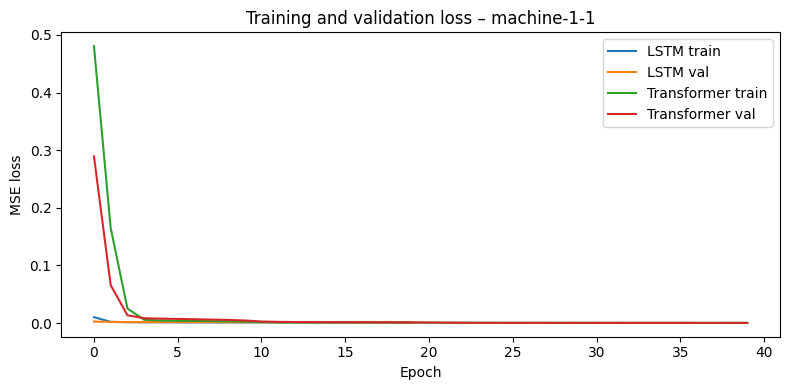

In [29]:

# ==== 6.6.1 Loss Curves for LSTM vs Transformer ====

if 'hist_lstm' in globals() and 'hist_transf' in globals():
    plt.figure(figsize=(8,4))
    plt.plot(hist_lstm["train_loss"],   label="LSTM train")
    plt.plot(hist_lstm["val_loss"],     label="LSTM val")
    plt.plot(hist_transf["train_loss"], label="Transformer train")
    plt.plot(hist_transf["val_loss"],   label="Transformer val")
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.title("Training and validation loss – machine-1-1")
    plt.legend()
    plt.tight_layout()
    plt.show()

### 6.6.2 Feature-level diagnosis (Transformer LN + MSE)

In [30]:

# ==== 6.6.2 Feature-level diagnosis with Transformer Autoencoder ====

if 'transf_model' in globals():
    print("\n=== Feature-level diagnosis (Transformer) ===")
    # 1. Compute feature-wise errors on train and test
    feat_errors_train_transf = compute_feature_level_errors(transf_model, train_windows)
    feat_errors_test_transf = compute_feature_level_errors(transf_model, test_windows)

    print("Feature-level error matrices:")
    print("  train:", feat_errors_train_transf.shape)
    print("  test :", feat_errors_test_transf.shape)

    # 2. Learn per-feature thresholds from training errors
    feat_thresholds_transf = choose_feature_thresholds(feat_errors_train_transf, quantile=0.995)

    # 3. Multi-label predictions per (time, feature)
    y_pred_feat_transf = compute_feature_level_predictions(feat_errors_test_transf, feat_thresholds_transf)
    print("Feature-level prediction matrix shape:", y_pred_feat_transf.shape)

    # 4. Inspect a few anomalous timestamps according to time-level Transformer detection
    if 'y_pred_transf' in globals():
        anomalous_times = np.where(y_pred_transf == 1)[0]
        print(f"Number of anomalous timestamps (time-level): {len(anomalous_times)}")

        for t in anomalous_times[:5]:  # show up to 5
            anomalous_features = np.where(y_pred_feat_transf[t] == 1)[0]
            print(f"t = {t:5d} | anomalous features (indices) = {anomalous_features}")
    else:
        print("Warning: 'y_pred_transf' not found – run the Transformer time-level detection first.")
else:
    print("Warning: 'transf_model' not found – train the Transformer model first.")



=== Feature-level diagnosis (Transformer) ===
Feature-level error matrices:
  train: (28479, 38)
  test : (28479, 38)
Feature-level prediction matrix shape: (28479, 38)
Number of anomalous timestamps (time-level): 3572
t =  3765 | anomalous features (indices) = [ 0  1  4  5  6  7  8  9 10 11 12 13 14 16 17 18 20 21 22 23 24 26 27 28
 29 30 31 32 33 35 36 37]
t =  3766 | anomalous features (indices) = [ 0  1  4  5  6  7  8  9 10 11 12 13 14 16 17 18 20 21 22 23 24 26 27 28
 29 30 31 32 33 35 36 37]
t =  3767 | anomalous features (indices) = [ 0  1  4  5  6  7  8  9 10 11 12 13 14 16 17 18 20 21 22 23 24 26 27 28
 29 30 31 32 33 35 36 37]
t =  3768 | anomalous features (indices) = [ 0  1  4  5  6  7  8  9 10 11 12 13 14 16 17 18 20 21 22 23 24 26 27 28
 29 30 31 32 33 34 35 36 37]
t =  3769 | anomalous features (indices) = [ 0  1  4  5  6  7  8  9 10 11 12 13 14 16 17 18 20 21 22 23 24 26 27 28
 29 30 31 32 33 34 35 36 37]


### 6.6.3 Error scale and outlier filtering (Transformer LN + MSE)

In [31]:
# ==== 6.6.3 Error scale and outlier filtering (Transformer) ====

train_scores = np.asarray(train_errors_transf)
test_scores  = np.asarray(test_errors_transf)

print("Train scores shape:", train_scores.shape)
print("Test  scores shape:", test_scores.shape)
print("Train scores  min / max:", float(train_scores.min()), float(train_scores.max()))
print("Test  scores  min / max:", float(test_scores.min()),  float(test_scores.max()))

# Check and filter extreme values
test_scores = np.asarray(test_errors_transf)
mask_good = np.isfinite(test_scores) & (test_scores < 1e3)

print("Original test scores:", test_scores.shape)
print("Non-finite values:", np.sum(~np.isfinite(test_scores)))
print("Extremely large values:", np.sum(test_scores >= 1e3))

test_scores_filtered = test_scores[mask_good]
print("Filtered test scores:", test_scores_filtered.shape)
print("Filtered min/max:", test_scores_filtered.min(), test_scores_filtered.max())


Train scores shape: (28479,)
Test  scores shape: (28479,)
Train scores  min / max: 1.841740777308587e-05 0.012155325151979923
Test  scores  min / max: 2.0591718566720374e-05 318174935384064.0
Original test scores: (28479,)
Non-finite values: 0
Extremely large values: 480
Filtered test scores: (27999,)
Filtered min/max: 2.0591719e-05 0.46733263


### 6.6.4 Error distribution (normal vs anomaly) – Transformer LN + MSE

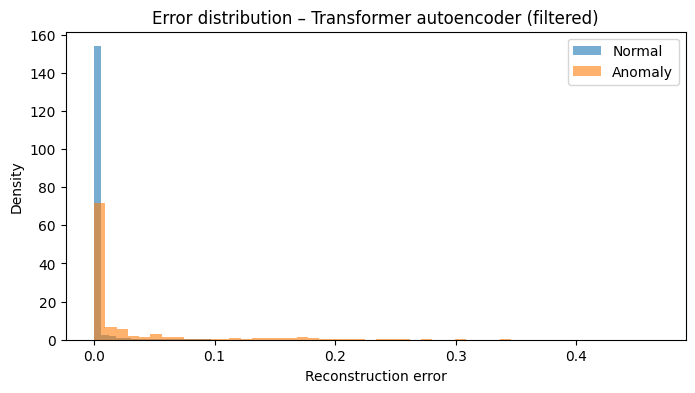

In [32]:
# ==== 6.6.4 Error distribution: normal vs anomaly ====

import numpy as np
import matplotlib.pyplot as plt

test_scores = np.asarray(test_errors_transf)

# stesso filtro che hai già usato
mask_good = np.isfinite(test_scores) & (test_scores < 1e3)
scores_good   = test_scores[mask_good]
labels_good   = test_labels[mask_good]

normal_scores  = scores_good[labels_good == 0]
anomaly_scores = scores_good[labels_good == 1]

plt.figure(figsize=(8,4))
plt.hist(normal_scores,  bins=50, density=True, alpha=0.6, label="Normal")
plt.hist(anomaly_scores, bins=50, density=True, alpha=0.6, label="Anomaly")
plt.xlabel("Reconstruction error")
plt.ylabel("Density")
plt.title("Error distribution – Transformer autoencoder (filtered)")
plt.legend()
plt.show()



### 6.6.5 Raw signal + reconstruction error (Transformer LN + MSE)

In [33]:
np.where(test_labels[3000:3800] == 1)[0]
# indici di tutti i timestamp anomali nel test set
anom_idx = np.where(test_labels == 1)[0]
anom_idx.min(), anom_idx.max()


(15849, 27555)

In [34]:
center = anom_idx[0]        # o anom_idx[100], ecc.
half_window = 200

t0 = max(0, center - half_window)
t1 = min(len(test_labels), center + half_window)

print(t0, t1)


15649 16049


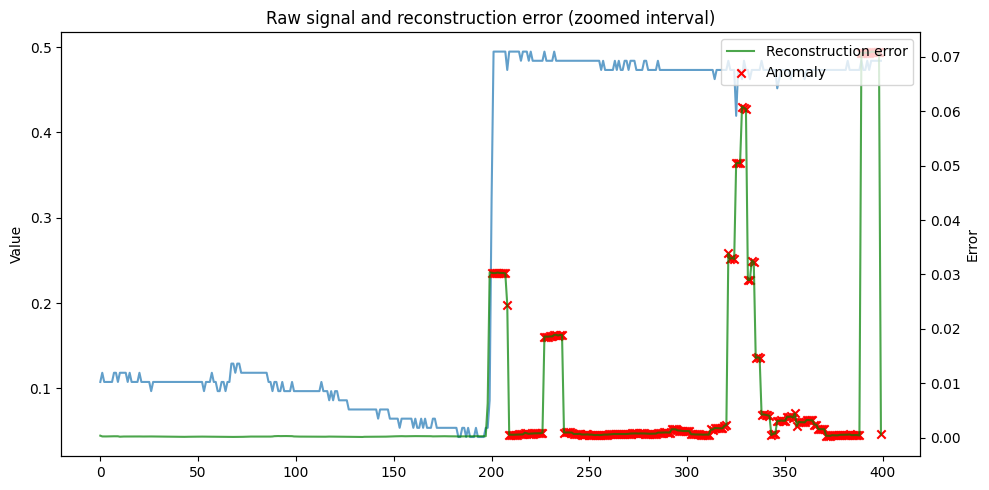

In [35]:
plt.figure(figsize=(10, 5))

# 1) raw feature
plt.plot(test_data[t0:t1, 0], label='Feature 0 (raw)', alpha=0.7)
plt.ylabel("Value")

# 2) reconstruction error on second y-axis
plt.twinx()
test_scores = test_errors_transf
plt.plot(test_scores[t0:t1], label='Reconstruction error', alpha=0.7, color='green')
plt.ylabel("Error")

# 3) anomalies
anomalous_idx = np.where(test_labels[t0:t1] == 1)[0]
plt.scatter(anomalous_idx,
            test_scores[t0:t1][anomalous_idx],
            marker='x',
            label='Anomaly',
            color='red')

plt.title("Raw signal and reconstruction error (zoomed interval)")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

### 6.6.6 Feature-wise reconstruction error heatmap (Transformer LN + MSE)

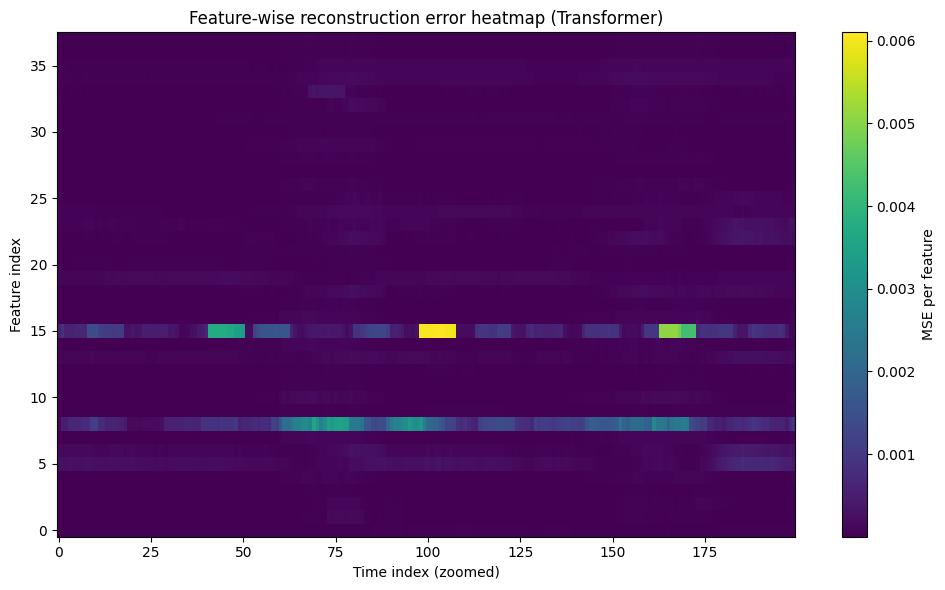

In [36]:
# ==== 6.6.6 Feature-wise reconstruction error heatmap (Transformer) ====

window = slice(900, 1100)   # interval containing an anomaly
subset = feat_errors_test_transf[window, :].T  # (D, time)

plt.figure(figsize=(10, 6))
plt.imshow(subset, aspect='auto', origin='lower')
plt.colorbar(label='MSE per feature')
plt.xlabel("Time index (zoomed)")
plt.ylabel("Feature index")
plt.title("Feature-wise reconstruction error heatmap (Transformer)")
plt.tight_layout()
plt.show()


---

## 6.6 Diagnostics for the Reference Transformer (LN + MSE)

This section provides detailed diagnostics for the reference Transformer autoencoder 
(LayerNorm + MSE loss), used as the baseline neural architecture.  
The goal is to understand its training behaviour, feature-level reconstruction patterns, 
numerical stability, and the separation between normal and anomalous error distributions.

---

### 6.6.1 Loss curves: LSTM vs Transformer (LN + MSE)

We compare the training and validation curves of the LSTM autoencoder and the 
Transformer (LN + MSE).  
The Transformer converges more slowly during the first epochs, but reaches a lower 
validation loss, indicating a better reconstruction capability on the normal manifold.

---

### 6.6.2 Feature-level diagnosis (Transformer LN + MSE)

We analyse per-feature reconstruction errors across the training and test windows.  
This allows us to inspect which KPIs contribute the most to an anomaly at each timestamp, 
and reveals that the baseline Transformer tends to distribute error across many features, 
making anomaly localisation difficult.

The diagnostic also reports which features are flagged as anomalous for the timestamps 
detected as anomalies by the model.

---

### 6.6.3 Error scale and outlier filtering (Transformer LN + MSE)

We inspect the raw reconstruction error range for both train and test sets.  
The baseline Transformer occasionally produces extremely large values 
(up to ~1e14), caused by numerical instabilities in the decoder and residual connections.  

We therefore apply an outlier filtering rule:

- keep only finite values  
- discard values ≥ 1e3  

This produces a stable, interpretable error distribution that can be used for thresholding 
and evaluation.

---

### 6.6.4 Error distribution (normal vs anomaly) – Transformer LN + MSE

Using the filtered scores, we compare the reconstruction error density of normal and 
anomalous timestamps.  
The two distributions largely overlap, explaining the limited maximum achievable F1-score 
for this architecture.  
The Transformer LN+MSE reacts strongly to local volatility, increasing false positives.

---

### 6.6.5 Raw signal + reconstruction error (Transformer LN + MSE)

We visualise a zoomed interval containing anomalies, showing:

- the raw KPI signal  
- the corresponding reconstruction error  
- ground-truth anomaly labels  

The baseline Transformer often raises spikes on normal-but-volatile points, illustrating 
its sensitivity to high-frequency fluctuations.

---

### 6.6.6 Feature-wise reconstruction error heatmap (Transformer LN + MSE)

Finally, we visualise a heatmap of reconstruction errors per feature over the same interval.  
The baseline Transformer shows diffuse activation across many features, instead of 
concentrating errors on the truly abnormal dimensions.  
This motivates the transition to the improved Best Transformer (LN + Huber) analysed in Section 8.

---


# 7. Refinement Experiments & Ablations

## 7.1 Ablation: window size (K = 10, 30, 50)

In [37]:
# ==== 9.1 Window-size ablation: K = 10, 30, 50 ====

import numpy as np
import pandas as pd
import torch.nn as nn # Added import
import torch # Added import

# Redefine TransformerAELN to accept max_len for positional embedding
class TransformerAELN_Ablation(nn.Module):
    def __init__(self, input_dim: int, d_model: int = 64, nhead: int = 4, num_layers: int = 1, max_len: int = 10):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, d_model)) # Use max_len here

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=0.1,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=0.1,
            norm_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(d_model, input_dim)
        self.final_norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        B, K, D = x.shape
        # Ensure positional embedding is sliced to match current sequence length K
        x = self.input_proj(x) + self.pos_embedding[:, :K, :]

        z = self.encoder(x)
        out = self.decoder(tgt=x, memory=z)
        out = self.output_proj(out)
        out = self.final_norm(out)
        return out

WINDOW_SIZES = [10, 30, 50]
EPOCHS_LSTM_ABL = 15     # you can increase if you have time (20–30)
EPOCHS_TRANSF_ABL = 20   # same

results_ws = []

for K in WINDOW_SIZES:
    print(f"\n\n=== Window size K = {K} ===")

    # 1) Reload and normalise data for the current machine
    train_data, test_data, test_labels = load_smd_machine(SMD_TRAIN_DIR, MACHINE_ID)
    train_norm, test_norm, data_min, data_max = min_max_normalize(train_data, test_data)

    # 2) Create sliding windows
    train_windows = create_sliding_windows(train_norm, K)
    test_windows  = create_sliding_windows(test_norm,  K)

    print("Train windows:", train_windows.shape, "Test windows:", test_windows.shape)

    # 3) Dataloaders
    train_loader, val_loader = create_dataloaders(
        train_windows, batch_size=BATCH_SIZE, val_ratio=0.2
    )

    input_dim = train_data.shape[1]

    # ------------ LSTM ------------
    print("\n[LSTM] Training...")
    lstm_model = LSTMAutoencoder(input_dim=input_dim, hidden_dim=64, latent_dim=32)
    _ = fit_model(lstm_model, train_loader, val_loader, num_epochs=EPOCHS_LSTM_ABL, lr=1e-3)

    train_errors_lstm = compute_reconstruction_errors(lstm_model, train_windows)
    test_errors_lstm  = compute_reconstruction_errors(lstm_model,  test_windows)

    thr_lstm = choose_threshold(train_errors_lstm, quantile=0.995)
    y_pred_lstm = compute_predictions(test_errors_lstm, thr_lstm)
    metrics_lstm = evaluate_anomaly_detection(test_labels, test_errors_lstm, y_pred_lstm)

    # ------------ Transformer (LayerNorm) ------------
    print("\n[Transformer LN] Training...")
    transf_model = TransformerAELN_Ablation( # Use the modified class here
        input_dim=input_dim,
        d_model=64,
        nhead=4,
        num_layers=1,
        max_len=K # Pass K as max_len
    )
    _ = fit_model(transf_model, train_loader, val_loader, num_epochs=EPOCHS_TRANSF_ABL, lr=1e-3)

    train_errors_transf = compute_reconstruction_errors(transf_model, train_windows)
    test_errors_transf  = compute_reconstruction_errors(transf_model,  test_windows)

    thr_transf = choose_threshold(train_errors_transf, quantile=0.995)
    y_pred_transf = compute_predictions(test_errors_transf, thr_transf)
    metrics_transf = evaluate_anomaly_detection(test_labels, test_errors_transf, y_pred_transf)

    # 4) Save results
    results_ws.append({
        "K": K,
        "model": "LSTM AE",
        **metrics_lstm
    })
    results_ws.append({
        "K": K,
        "model": "Transformer AE (LN)",
        **metrics_transf
    })

# 5) Summary table
df_ws = pd.DataFrame(results_ws)
print("\n=== Window-size ablation summary ===")
display(df_ws)



=== Window size K = 10 ===
Loaded SMD machine machine-1-1
Train shape: (28479, 38)
Test  shape: (28479, 38)
Labels shape: (28479,)
Number of anomalous points in test: 2694
Train windows: (28479, 10, 38) Test windows: (28479, 10, 38)

[LSTM] Training...
Epoch 001 | train_loss=0.010220 | val_loss=0.002482
Epoch 002 | train_loss=0.001954 | val_loss=0.002041
Epoch 003 | train_loss=0.001422 | val_loss=0.001696
Epoch 004 | train_loss=0.001303 | val_loss=0.001664
Epoch 005 | train_loss=0.001263 | val_loss=0.001599
Epoch 006 | train_loss=0.001237 | val_loss=0.001590
Epoch 007 | train_loss=0.001217 | val_loss=0.001539
Epoch 008 | train_loss=0.001202 | val_loss=0.001555
Epoch 009 | train_loss=0.001185 | val_loss=0.001509
Epoch 010 | train_loss=0.001173 | val_loss=0.001488
Epoch 011 | train_loss=0.001158 | val_loss=0.001458
Epoch 012 | train_loss=0.001149 | val_loss=0.001446
Epoch 013 | train_loss=0.001134 | val_loss=0.001449
Epoch 014 | train_loss=0.001121 | val_loss=0.001401
Epoch 015 | train

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.482903 | val_loss=0.294030
Epoch 002 | train_loss=0.170687 | val_loss=0.071689
Epoch 003 | train_loss=0.026043 | val_loss=0.014349
Epoch 004 | train_loss=0.005912 | val_loss=0.010064
Epoch 005 | train_loss=0.004701 | val_loss=0.009288
Epoch 006 | train_loss=0.004351 | val_loss=0.008862
Epoch 007 | train_loss=0.004042 | val_loss=0.008364
Epoch 008 | train_loss=0.003677 | val_loss=0.007730
Epoch 009 | train_loss=0.003369 | val_loss=0.007234
Epoch 010 | train_loss=0.003143 | val_loss=0.006675
Epoch 011 | train_loss=0.002962 | val_loss=0.006430
Epoch 012 | train_loss=0.002802 | val_loss=0.006048
Epoch 013 | train_loss=0.002631 | val_loss=0.005587
Epoch 014 | train_loss=0.002400 | val_loss=0.004749
Epoch 015 | train_loss=0.001786 | val_loss=0.002501
Epoch 016 | train_loss=0.000896 | val_loss=0.001510
Epoch 017 | train_loss=0.000720 | val_loss=0.001110
Epoch 018 | train_loss=0.000641 | val_loss=0.001027
Epoch 019 | train_loss=0.000555 | val_loss=0.000770
Epoch 020 | 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.479349 | val_loss=0.285757
Epoch 002 | train_loss=0.160590 | val_loss=0.063715
Epoch 003 | train_loss=0.025591 | val_loss=0.015909
Epoch 004 | train_loss=0.006457 | val_loss=0.011093
Epoch 005 | train_loss=0.005024 | val_loss=0.009829
Epoch 006 | train_loss=0.004642 | val_loss=0.009283
Epoch 007 | train_loss=0.004332 | val_loss=0.008942
Epoch 008 | train_loss=0.004083 | val_loss=0.008613
Epoch 009 | train_loss=0.003772 | val_loss=0.008152
Epoch 010 | train_loss=0.003509 | val_loss=0.007797
Epoch 011 | train_loss=0.003277 | val_loss=0.007558
Epoch 012 | train_loss=0.003106 | val_loss=0.007219
Epoch 013 | train_loss=0.002984 | val_loss=0.006950
Epoch 014 | train_loss=0.002863 | val_loss=0.006562
Epoch 015 | train_loss=0.002691 | val_loss=0.005960
Epoch 016 | train_loss=0.002322 | val_loss=0.004767
Epoch 017 | train_loss=0.001329 | val_loss=0.002414
Epoch 018 | train_loss=0.001010 | val_loss=0.001796
Epoch 019 | train_loss=0.000954 | val_loss=0.001602
Epoch 020 | 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.482463 | val_loss=0.291771
Epoch 002 | train_loss=0.172817 | val_loss=0.074700
Epoch 003 | train_loss=0.027478 | val_loss=0.014646
Epoch 004 | train_loss=0.005926 | val_loss=0.010165
Epoch 005 | train_loss=0.004900 | val_loss=0.009237
Epoch 006 | train_loss=0.004678 | val_loss=0.008775
Epoch 007 | train_loss=0.004391 | val_loss=0.008461
Epoch 008 | train_loss=0.004125 | val_loss=0.008176
Epoch 009 | train_loss=0.003881 | val_loss=0.007707
Epoch 010 | train_loss=0.003529 | val_loss=0.007200
Epoch 011 | train_loss=0.003250 | val_loss=0.006836
Epoch 012 | train_loss=0.003024 | val_loss=0.006460
Epoch 013 | train_loss=0.002797 | val_loss=0.005845
Epoch 014 | train_loss=0.002471 | val_loss=0.004409
Epoch 015 | train_loss=0.001902 | val_loss=0.002995
Epoch 016 | train_loss=0.001013 | val_loss=0.001568
Epoch 017 | train_loss=0.000775 | val_loss=0.001215
Epoch 018 | train_loss=0.000727 | val_loss=0.001087
Epoch 019 | train_loss=0.000695 | val_loss=0.001002
Epoch 020 | 

,K,model,precision,recall,f1,auc_roc,auc_pr
0,10,LSTM AE,0.184956,0.986637,0.311515,0.875845,0.505902
1,10,Transformer AE (LN),0.354416,0.461767,0.401032,0.876746,0.445530
2,30,LSTM AE,0.185539,0.994432,0.312730,0.891750,0.497417
3,30,Transformer AE (LN),0.342667,0.476986,0.398821,0.875723,0.418952
4,50,LSTM AE,0.217146,0.984410,0.355806,0.896355,0.467247
5,50,Transformer AE (LN),0.357374,0.533408,0.427997,0.890619,0.415732


## 7.2 Transformer AE (LN + Dropout + Huber)

This section evaluates the Transformer model with Layer Normalization, increased dropout, and trained using the Huber loss (SmoothL1Loss) for improved robustness. This combination aims to enhance stability and performance, especially in the presence of outliers in the error distribution.

In [38]:
# ==== 9.2.1 TransformerAELNDrop: LN + higher dropout ====

import torch
import torch.nn as nn

class TransformerAELNDrop(nn.Module):
    """
    Transformer autoencoder with LayerNorm, higher dropout and learned positional embeddings.
    """
    def __init__(self, input_dim=38, d_model=64, nhead=4, num_layers=1, max_len=512, dropout=0.3):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model

        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_embedding = nn.Embedding(max_len, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=dropout,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=dropout,
            norm_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.output_proj = nn.Linear(d_model, input_dim)
        self.final_norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        # x: (B, K, D)
        B, K, D = x.shape
        pos_ids = torch.arange(0, K, device=x.device).unsqueeze(0).repeat(B, 1)
        x = self.input_proj(x) + self.pos_embedding(pos_ids)
        z = self.encoder(x)
        out = self.decoder(tgt=x, memory=z)
        out = self.output_proj(out)
        out = self.final_norm(out)
        return out

In [39]:
# ==== 9.2.2 Transformer (LN + Dropout + Huber loss) ====

import torch.nn as nn
import numpy as np

def fit_model_huber(
    model: nn.Module,
    train_loader,
    val_loader,
    num_epochs: int = 20,
    lr: float = 1e-3,
    weight_decay: float = 1e-5,
    delta: float = 1.0
):
    """
    Training loop with Huber (SmoothL1) loss.
    """
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.SmoothL1Loss(beta=delta)  # Huber-style loss

    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, num_epochs + 1):
        # --- train ---
        model.train()
        total_train, n_train = 0.0, 0
        for batch in train_loader:
            x = batch.to(device).float()
            recon = model(x)
            loss = criterion(recon, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train += loss.item() * x.size(0)
            n_train += x.size(0)
        train_loss = total_train / n_train

        # --- val ---
        model.eval()
        total_val, n_val = 0.0, 0
        with torch.no_grad():
            for batch in val_loader:
                x = batch.to(device).float()
                recon = model(x)
                loss = criterion(recon, x)
                total_val += loss.item() * x.size(0)
                n_val += x.size(0)
        val_loss = total_val / n_val

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        print(f"Epoch {epoch:03d} | train_loss={train_loss:.6f} | val_loss={val_loss:.6f}")

    return history

# ---- Run Huber Transformer on current machine and window size ----

print("\n=== 9.2 Transformer (LN + Dropout + Huber loss) ===")

# Usa gli stessi train_windows / test_windows / train_loader / val_loader già costruiti
# (per esempio con K=10 oppure K=30 se hai già fatto l'ablation)

transf_huber = TransformerAELNDrop(input_dim=input_dim, d_model=64, nhead=4, num_layers=1, dropout=0.3)
hist_transf_huber = fit_model_huber(
    transf_huber,
    train_loader,
    val_loader,
    num_epochs=40,
    lr=1e-3,
    delta=1.0
)

train_errors_huber = compute_reconstruction_errors(transf_huber, train_windows)
test_errors_huber  = compute_reconstruction_errors(transf_huber,  test_windows)

# soglia + metriche
thr_huber = choose_threshold(train_errors_huber, quantile=0.995)
y_pred_huber = compute_predictions(test_errors_huber, thr_huber)
metrics_huber = evaluate_anomaly_detection(test_labels, test_errors_huber, y_pred_huber)

print("\n[Transformer Huber] metrics:", metrics_huber)


=== 9.2 Transformer (LN + Dropout + Huber loss) ===


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.149366 | val_loss=0.108065
Epoch 002 | train_loss=0.077320 | val_loss=0.059463
Epoch 003 | train_loss=0.038380 | val_loss=0.021903
Epoch 004 | train_loss=0.009230 | val_loss=0.005353
Epoch 005 | train_loss=0.002743 | val_loss=0.004161
Epoch 006 | train_loss=0.002255 | val_loss=0.003793
Epoch 007 | train_loss=0.002035 | val_loss=0.003491
Epoch 008 | train_loss=0.001722 | val_loss=0.003119
Epoch 009 | train_loss=0.001443 | val_loss=0.002807
Epoch 010 | train_loss=0.001212 | val_loss=0.002443
Epoch 011 | train_loss=0.001041 | val_loss=0.002136
Epoch 012 | train_loss=0.000878 | val_loss=0.001741
Epoch 013 | train_loss=0.000723 | val_loss=0.001478
Epoch 014 | train_loss=0.000573 | val_loss=0.001131
Epoch 015 | train_loss=0.000362 | val_loss=0.000646
Epoch 016 | train_loss=0.000242 | val_loss=0.000488
Epoch 017 | train_loss=0.000215 | val_loss=0.000428
Epoch 018 | train_loss=0.000197 | val_loss=0.000375
Epoch 019 | train_loss=0.000186 | val_loss=0.000354
Epoch 020 | 

## 7.3 Multi-machine evaluation (3–4 machines)

In [40]:
# ==== 9.3 Multi-machine evaluation (3–4 machines) ====

import numpy as np
import pandas as pd

MACHINES = [
    "machine-1-1",
    "machine-1-2",
    "machine-1-3",
    "machine-2-1"
]

K_MULTI = 10          # you can also use 30 if you've already seen that it works better
EPOCHS_MULTI = 20
BATCH_SIZE = 128

multi_results = []

for mid in MACHINES:
    print(f"\n\n===== Machine: {mid} ====")

    # 1) Load + normalise
    train_data, test_data, test_labels = load_smd_machine(SMD_TRAIN_DIR, mid)
    train_norm, test_norm, data_min, data_max = min_max_normalize(train_data, test_data)

    # 2) Windows
    train_windows = create_sliding_windows(train_norm, K_MULTI)
    test_windows  = create_sliding_windows(test_norm,  K_MULTI)
    print("Train windows:", train_windows.shape, "Test windows:", test_windows.shape)

    # 3) Dataloaders
    train_loader, val_loader = create_dataloaders(
        train_windows, batch_size=BATCH_SIZE, val_ratio=0.2
    )
    input_dim = train_data.shape[1]

    # 4) Train best Transformer variant (LN, 40 epochs or 20 to save time)
    transf_model = TransformerAELN(
        input_dim=input_dim,
        d_model=64,
        nhead=4,
        num_layers=1
    )
    _ = fit_model(transf_model, train_loader, val_loader, num_epochs=EPOCHS_MULTI, lr=1e-3)

    train_errors_transf = compute_reconstruction_errors(transf_model, train_windows)
    test_errors_transf  = compute_reconstruction_errors(transf_model,  test_windows)

    thr_transf = choose_threshold(train_errors_transf, quantile=0.995)
    y_pred_transf = compute_predictions(test_errors_transf, thr_transf)
    metrics_transf = evaluate_anomaly_detection(test_labels, test_errors_transf, y_pred_transf)

    print(f"[{mid}] Transformer metrics:", metrics_transf)

    row = {"machine": mid, **metrics_transf}
    multi_results.append(row)

# Summary table across machines
df_multi = pd.DataFrame(multi_results)
print("\n=== Multi-machine summary (Transformer) ===")
display(df_multi)

print("\n=== Average metrics across machines ===")
print(df_multi.mean(numeric_only=True))



===== Machine: machine-1-1 ====
Loaded SMD machine machine-1-1
Train shape: (28479, 38)
Test  shape: (28479, 38)
Labels shape: (28479,)
Number of anomalous points in test: 2694
Train windows: (28479, 10, 38) Test windows: (28479, 10, 38)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.480584 | val_loss=0.290030
Epoch 002 | train_loss=0.164642 | val_loss=0.065726
Epoch 003 | train_loss=0.025941 | val_loss=0.014654
Epoch 004 | train_loss=0.005998 | val_loss=0.009216
Epoch 005 | train_loss=0.004340 | val_loss=0.008263
Epoch 006 | train_loss=0.003886 | val_loss=0.007716
Epoch 007 | train_loss=0.003486 | val_loss=0.007177
Epoch 008 | train_loss=0.003183 | val_loss=0.006703
Epoch 009 | train_loss=0.002966 | val_loss=0.006179
Epoch 010 | train_loss=0.002774 | val_loss=0.005677
Epoch 011 | train_loss=0.002594 | val_loss=0.005190
Epoch 012 | train_loss=0.002436 | val_loss=0.004792
Epoch 013 | train_loss=0.002288 | val_loss=0.004500
Epoch 014 | train_loss=0.002118 | val_loss=0.004069
Epoch 015 | train_loss=0.001827 | val_loss=0.002671
Epoch 016 | train_loss=0.001184 | val_loss=0.001470
Epoch 017 | train_loss=0.000952 | val_loss=0.001126
Epoch 018 | train_loss=0.000906 | val_loss=0.000997
Epoch 019 | train_loss=0.000889 | val_loss=0.000945
Epoch 020 | 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.583777 | val_loss=0.409323
Epoch 002 | train_loss=0.239304 | val_loss=0.118614
Epoch 003 | train_loss=0.053914 | val_loss=0.018821
Epoch 004 | train_loss=0.008704 | val_loss=0.003538
Epoch 005 | train_loss=0.002348 | val_loss=0.001381
Epoch 006 | train_loss=0.001269 | val_loss=0.000998
Epoch 007 | train_loss=0.000887 | val_loss=0.000777
Epoch 008 | train_loss=0.000689 | val_loss=0.000699
Epoch 009 | train_loss=0.000598 | val_loss=0.000656
Epoch 010 | train_loss=0.000554 | val_loss=0.000613
Epoch 011 | train_loss=0.000527 | val_loss=0.000610
Epoch 012 | train_loss=0.000510 | val_loss=0.000582
Epoch 013 | train_loss=0.000495 | val_loss=0.000573
Epoch 014 | train_loss=0.000488 | val_loss=0.000566
Epoch 015 | train_loss=0.000481 | val_loss=0.000561
Epoch 016 | train_loss=0.000476 | val_loss=0.000570
Epoch 017 | train_loss=0.000471 | val_loss=0.000545
Epoch 018 | train_loss=0.000467 | val_loss=0.000544
Epoch 019 | train_loss=0.000464 | val_loss=0.000539
Epoch 020 | 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.457285 | val_loss=0.378783
Epoch 002 | train_loss=0.195064 | val_loss=0.153408
Epoch 003 | train_loss=0.059430 | val_loss=0.043330
Epoch 004 | train_loss=0.013612 | val_loss=0.027597
Epoch 005 | train_loss=0.007181 | val_loss=0.026451
Epoch 006 | train_loss=0.006031 | val_loss=0.026584
Epoch 007 | train_loss=0.005651 | val_loss=0.026579
Epoch 008 | train_loss=0.005310 | val_loss=0.026179
Epoch 009 | train_loss=0.005073 | val_loss=0.026157
Epoch 010 | train_loss=0.004875 | val_loss=0.025734
Epoch 011 | train_loss=0.004696 | val_loss=0.025918
Epoch 012 | train_loss=0.004528 | val_loss=0.026058
Epoch 013 | train_loss=0.004369 | val_loss=0.025626
Epoch 014 | train_loss=0.004215 | val_loss=0.025028
Epoch 015 | train_loss=0.004070 | val_loss=0.024628
Epoch 016 | train_loss=0.003933 | val_loss=0.023681
Epoch 017 | train_loss=0.003799 | val_loss=0.022935
Epoch 018 | train_loss=0.003669 | val_loss=0.022281
Epoch 019 | train_loss=0.003536 | val_loss=0.021815
Epoch 020 | 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.557851 | val_loss=0.374852
Epoch 002 | train_loss=0.238696 | val_loss=0.138380
Epoch 003 | train_loss=0.070127 | val_loss=0.024653
Epoch 004 | train_loss=0.013362 | val_loss=0.005322
Epoch 005 | train_loss=0.005169 | val_loss=0.002895
Epoch 006 | train_loss=0.003319 | val_loss=0.002383
Epoch 007 | train_loss=0.002766 | val_loss=0.002254
Epoch 008 | train_loss=0.002479 | val_loss=0.002065
Epoch 009 | train_loss=0.002285 | val_loss=0.001899
Epoch 010 | train_loss=0.002153 | val_loss=0.001788
Epoch 011 | train_loss=0.002046 | val_loss=0.001679
Epoch 012 | train_loss=0.001959 | val_loss=0.001618
Epoch 013 | train_loss=0.001888 | val_loss=0.001592
Epoch 014 | train_loss=0.001827 | val_loss=0.001529
Epoch 015 | train_loss=0.001771 | val_loss=0.001486
Epoch 016 | train_loss=0.001720 | val_loss=0.001456
Epoch 017 | train_loss=0.001670 | val_loss=0.001434
Epoch 018 | train_loss=0.001624 | val_loss=0.001383
Epoch 019 | train_loss=0.001577 | val_loss=0.001341
Epoch 020 | 

,machine,precision,recall,f1,auc_roc,auc_pr
0,machine-1-1,0.558151,0.815887,0.662847,0.944813,0.572604
1,machine-1-2,0.600917,0.241697,0.344737,0.898488,0.403271
2,machine-1-3,0.090226,0.088127,0.089164,0.495974,0.070818
3,machine-2-1,0.739837,0.077778,0.140758,0.623186,0.206824



=== Average metrics across machines ===
precision    0.497283
recall       0.305872
f1           0.309376
auc_roc      0.740615
auc_pr       0.313379
dtype: float64


## 7.4 Threshold smoothing: moving average + std-boost

In [41]:
# ==== 9.4 Threshold smoothing: moving average + std-boost ====

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Assumiamo che train_errors_transf_long e test_errors_transf_long
# siano gli errori del "miglior" Transformer (LN, 40 epochs, K scelto)
train_scores = np.asarray(train_errors_transf_long)
test_scores  = np.asarray(test_errors_transf_long)

print("Train scores:", train_scores.shape, "Test scores:", test_scores.shape)

# Fix: Reload test_labels for the specific machine that test_errors_transf_long corresponds to (machine-1-1)
_, _, y_true_fixed = load_smd_machine(SMD_TRAIN_DIR, MACHINE_ID)
# Ensure y_true_fixed is not None, otherwise default to existing test_labels if no label file
if y_true_fixed is not None:
    y_true = y_true_fixed
else:
    y_true = test_labels # Fallback to the last loaded test_labels, though this might still be incorrect if MACHINE_ID labels are missing.


# 1) Moving average smoothing on test scores
def moving_average(x, window=5):
    if window <= 1:
        return x
    kernel = np.ones(window) / window
    y = np.convolve(x, kernel, mode="same")
    return y

WINDOW_SMOOTH = 5
test_scores_smooth = moving_average(test_scores, window=WINDOW_SMOOTH)

# 2) Threshold strategies
# 2.a) Quantile-based (baseline)
q = 0.995
thr_quant = np.quantile(train_scores, q)

# 2.b) Mean + lambda * std (std-boost) on training scores
mu = train_scores.mean()
sigma = train_scores.std()
LAMBDA = 3.0   # 3 std above mean
thr_std = mu + LAMBDA * sigma

print(f"Quantile thr (q={q}): {thr_quant:.4f}")
print(f"Std-boost thr (mu + {LAMBDA}*sigma): {thr_std:.4f}")

# 3) Predictions
# y_true = test_labels  # Original line: this was causing the mismatch

# Without smoothing
y_pred_quant_raw = (test_scores >= thr_quant).astype(int)
y_pred_std_raw   = (test_scores >= thr_std).astype(int)

# With smoothing
y_pred_quant_smooth = (test_scores_smooth >= thr_quant).astype(int)
y_pred_std_smooth   = (test_scores_smooth >= thr_std).astype(int)

def compute_basic_metrics(y_true, y_pred):
    p = precision_score(y_true, y_pred, zero_division=0)
    r = recall_score(y_true, y_pred, zero_division=0)
    f = f1_score(y_true, y_pred, zero_division=0)
    return p, r, f

print("\n=== Threshold comparison (no smoothing) ===")
print("Quantile (raw):   P,R,F1 =", compute_basic_metrics(y_true, y_pred_quant_raw))
print("Std-boost (raw):  P,R,F1 =", compute_basic_metrics(y_true, y_pred_std_raw))

print("\n=== Threshold comparison (with smoothing, MA window=5) ===")
print("Quantile (smooth): P,R,F1 =", compute_basic_metrics(y_true, y_pred_quant_smooth))
print("Std-boost (smooth):P,R,F1 =", compute_basic_metrics(y_true, y_pred_std_smooth))

Train scores: (28479,) Test scores: (28479,)
Loaded SMD machine machine-1-1
Train shape: (28479, 38)
Test  shape: (28479, 38)
Labels shape: (28479,)
Number of anomalous points in test: 2694
Quantile thr (q=0.995): 0.0027
Std-boost thr (mu + 3.0*sigma): 0.0017

=== Threshold comparison (no smoothing) ===
Quantile (raw):   P,R,F1 = (0.35595703125, 0.5412026726057907, 0.4294550810014727)
Std-boost (raw):  P,R,F1 = (0.3308181096108022, 0.6184112843355605, 0.4310478654592496)

=== Threshold comparison (with smoothing, MA window=5) ===
Quantile (smooth): P,R,F1 = (0.3625660740028832, 0.5601336302895323, 0.4401983663943991)
Std-boost (smooth):P,R,F1 = (0.3368565276962224, 0.6388270230141054, 0.4411123926694861)


## 7.5 Transformer AE LN + Drop: higher dropout + Sigmoid

In [42]:
# ==== 9.5 TransformerAELNDrop: LN + higher dropout + Sigmoid ====

import torch
import torch.nn as nn

class TransformerAELNDrop(nn.Module):
    """
    Transformer autoencoder with LayerNorm, higher dropout and learned positional embeddings.
    Output bounded in [0,1] via Sigmoid.
    """
    def __init__(
        self,
        input_dim: int = 38,
        d_model: int = 64,
        nhead: int = 4,
        num_layers: int = 1,
        max_len: int = 512,
        dropout: float = 0.3
    ):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model

        # Proiezione input + posizioni
        self.input_proj    = nn.Linear(input_dim, d_model)
        self.pos_embedding = nn.Embedding(max_len, d_model)

        # Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=dropout,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=dropout,
            norm_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # Output: un solo Linear + Sigmoid
        self.output_layer      = nn.Linear(d_model, input_dim)
        self.output_activation = nn.Sigmoid()  # vincola a [0,1]

    def forward(self, x):
        # x: (B, K, D)
        B, K, D = x.shape

        # Positional IDs
        pos_ids = torch.arange(0, K, device=x.device).unsqueeze(0).repeat(B, 1)

        # Input embedding + pos embedding
        x_emb = self.input_proj(x) + self.pos_embedding(pos_ids)

        # Encoder → latent z
        z = self.encoder(x_emb)

        # Decoder (usa le stesse posizioni come tgt)
        dec = self.decoder(tgt=x_emb, memory=z)

        # Output proiettato nello spazio input + Sigmoid
        out = self.output_layer(dec)
        out = self.output_activation(out)

        return out


## 7.6 Transformer AE (LN + Dropout + Huber + Sigmoid + Clipping)

In [43]:
import torch
import torch.nn as nn
import numpy as np

def fit_model_huber(
    model: nn.Module,
    train_loader,
    val_loader,
    num_epochs: int = 40,
    lr: float = 5e-4,
    weight_decay: float = 1e-5,
    delta: float = 1.0,
    max_grad_norm: float = 1.0
):
    """
    Training loop with Huber (SmoothL1) loss + gradient clipping.
    """
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.SmoothL1Loss(beta=delta)  # Huber-style loss

    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, num_epochs + 1):
        # --- train ---
        model.train()
        total_train, n_train = 0.0, 0

        for batch in train_loader:
            x = batch.to(device).float()
            recon = model(x)
            loss = criterion(recon, x)

            optimizer.zero_grad()
            loss.backward()

            # 🔹 Gradient clipping qui
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)

            optimizer.step()

            total_train += loss.item() * x.size(0)
            n_train += x.size(0)

        train_loss = total_train / n_train

        # --- val ---
        model.eval()
        total_val, n_val = 0.0, 0
        with torch.no_grad():
            for batch in val_loader:
                x = batch.to(device).float()
                recon = model(x)
                loss = criterion(recon, x)
                total_val += loss.item() * x.size(0)
                n_val += x.size(0)
        val_loss = total_val / n_val

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        print(f"Epoch {epoch:03d} | train_loss={train_loss:.6f} | val_loss={val_loss:.6f}")

    return history


In [44]:
print("\n=== Transformer (LN + Dropout + Huber + Sigmoid + Clipping) ===")

best_model = TransformerAELNDrop(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1,
    dropout=0.3
)

hist_best = fit_model_huber(
    best_model,
    train_loader,
    val_loader,
    num_epochs=40,
    lr=5e-4,
    delta=1.0,
    max_grad_norm=1.0
)

train_errors_best = compute_reconstruction_errors(best_model, train_windows)
test_errors_best  = compute_reconstruction_errors(best_model,  test_windows)

thr_best = choose_threshold(train_errors_best, quantile=0.995)
y_pred_best = compute_predictions(test_errors_best, thr_best)
metrics_best = evaluate_anomaly_detection(test_labels, test_errors_best, y_pred_best)

print("\n[Best Transformer Stabilized] metrics:", metrics_best)



=== Transformer (LN + Dropout + Huber + Sigmoid + Clipping) ===


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.010207 | val_loss=0.002400
Epoch 002 | train_loss=0.002382 | val_loss=0.001720
Epoch 003 | train_loss=0.001635 | val_loss=0.001227
Epoch 004 | train_loss=0.001243 | val_loss=0.000899
Epoch 005 | train_loss=0.001007 | val_loss=0.000841
Epoch 006 | train_loss=0.000877 | val_loss=0.000809
Epoch 007 | train_loss=0.000796 | val_loss=0.000766
Epoch 008 | train_loss=0.000738 | val_loss=0.000741
Epoch 009 | train_loss=0.000689 | val_loss=0.000718
Epoch 010 | train_loss=0.000647 | val_loss=0.000673
Epoch 011 | train_loss=0.000599 | val_loss=0.000652
Epoch 012 | train_loss=0.000546 | val_loss=0.000599
Epoch 013 | train_loss=0.000506 | val_loss=0.000574
Epoch 014 | train_loss=0.000482 | val_loss=0.000568
Epoch 015 | train_loss=0.000464 | val_loss=0.000549
Epoch 016 | train_loss=0.000450 | val_loss=0.000542
Epoch 017 | train_loss=0.000437 | val_loss=0.000539
Epoch 018 | train_loss=0.000426 | val_loss=0.000530
Epoch 019 | train_loss=0.000416 | val_loss=0.000522
Epoch 020 | 

## 7.7 Segment cleaning and post-processing

In [45]:
import numpy as np


def clean_segments(preds: np.ndarray, min_len: int = 3) -> np.ndarray:
    """
    Removes anomalous segments that are too short.
    preds: binary array (T,)
    min_len: minimum length of a contiguous segment of 1s to keep.
    """
    preds = preds.copy()
    T = len(preds)
    start = None

    for t in range(T):
        if preds[t] == 1 and start is None:
            start = t
        # end of segment if we return to 0 or we are at the last index
        if (preds[t] == 0 or t == T - 1) and start is not None:
            end = t if preds[t] == 0 else t + 1  # end is exclusive
            if end - start < min_len:
                preds[start:end] = 0
            start = None

    return preds

In [46]:
# --- Segment post-processing to increase precision ---
min_segment_len = 3  # you can try 2, 3, 5...

# y_pred_best is a binary array (T,)
y_pred_clean = clean_segments(y_pred_best, min_len=min_segment_len)
metrics_best_clean = evaluate_anomaly_detection(test_labels, test_errors_best, y_pred_clean)

print(f"\n[Best Transformer + segment cleaning (min_len={min_segment_len})] metrics:",
      metrics_best_clean)


[Best Transformer + segment cleaning (min_len=3)] metrics: {'precision': 0.42332613390928725, 'recall': 0.335042735042735, 'f1': 0.37404580152671757, 'auc_roc': 0.6591627999459645, 'auc_pr': 0.31040160253992577}


## 7.8 Self-adversarial conditioning model + moving average

In [47]:
import numpy as np

def moving_average_1d(x: np.ndarray, k: int = 5) -> np.ndarray:
    """
    1D moving average with window size k.
    Returns an array of the same length as x (edge padding).
    """
    assert k >= 1 and k % 2 == 1, "k must be odd for simple alignment."

    T = len(x)
    # simple convolution via cumsum
    cumsum = np.cumsum(np.insert(x, 0, 0.0))
    ma = (cumsum[k:] - cumsum[:-k]) / float(k)  # length T - k + 1

    # padding to have length T
    pad_left = k // 2
    pad_right = T - len(ma) - pad_left
    ma_padded = np.pad(ma, (pad_left, pad_right), mode="edge")
    return ma_padded


def self_condition_scores(train_scores: np.ndarray,
                          test_scores: np.ndarray,
                          k: int = 5,
                          beta: float = 2.0):
    """
    Constructs self-conditioned scores for train and test using a moving average
    + re-weighting:
        score_focus = score * (1 + beta * ma_norm)

    Returns:
      train_scores_focus, test_scores_focus
    """
    # Moving average on train and test
    ma_train = moving_average_1d(train_scores, k=k)
    ma_test  = moving_average_1d(test_scores,  k=k)

    # Normalize the moving average on training data only (as "fit")
    ma_min = ma_train.min()
    ma_max = ma_train.max()
    denom = (ma_max - ma_min) + 1e-8

    ma_train_norm = (ma_train - ma_min) / denom
    ma_test_norm  = (ma_test  - ma_min) / denom  # same scale as train

    # Self-conditioning: amplify errors where the moving average is high
    train_focus = train_scores * (1.0 + beta * ma_train_norm)
    test_focus  = test_scores  * (1.0 + beta * ma_test_norm)

    return train_focus, test_focus

In [48]:
# --- Self-conditioned scores ("light" focus) ---
k_focus = 5     # window width (odd)
beta_focus = 2.0  # focus strength

train_errors_focus, test_errors_focus = self_condition_scores(
    train_errors_best,
    test_errors_best,
    k=k_focus,
    beta=beta_focus
)

# Threshold based on self-conditioned train scores
thr_focus = choose_threshold(train_errors_focus, quantile=0.995)

# Predictions with self-conditioned scores
y_pred_focus = compute_predictions(test_errors_focus, thr_focus)
metrics_focus = evaluate_anomaly_detection(test_labels, test_errors_focus, y_pred_focus)

print(f"\n[Best Transformer + self-conditioned scores (k={k_focus}, beta={beta_focus})] metrics:",
      metrics_focus)

# And if you want, combine self-conditioning + segment cleaning:
y_pred_focus_clean = clean_segments(y_pred_focus, min_len=min_segment_len)
metrics_focus_clean = evaluate_anomaly_detection(test_labels, test_errors_focus, y_pred_focus_clean)

print(f"[Best Transformer + self-conditioned + segment cleaning] metrics:",
      metrics_focus_clean)


[Best Transformer + self-conditioned scores (k=5, beta=2.0)] metrics: {'precision': 0.42749731471535984, 'recall': 0.3401709401709402, 'f1': 0.378867206092337, 'auc_roc': 0.6629088326677565, 'auc_pr': 0.31518017748522165}
[Best Transformer + self-conditioned + segment cleaning] metrics: {'precision': 0.4301191765980498, 'recall': 0.33931623931623933, 'f1': 0.3793597706641185, 'auc_roc': 0.6629088326677565, 'auc_pr': 0.31518017748522165}


## 7.9 Transformer AE (LN + Dropout + Huber + Sigmoid + Semi-Adversarial)

In [49]:
import torch

def inject_spikes(x: torch.Tensor,
                  n_features: int = 3,
                  spike_scale: float = 5.0) -> torch.Tensor:
    """
    Injects random spikes into a batch of sequences.
    x: (B, K, D)
    n_features: number of features to modify per spike.
    spike_scale: magnitude of the spike (multiplicative).
    """
    x_anom = x.clone()
    B, K, D = x.shape

    # Choose random time steps for spikes (one per sequence in batch)
    spike_ts = torch.randint(0, K, (B,), device=x.device)

    for i in range(B):
        # Choose random features to spike
        features_to_spike = torch.randperm(D)[:n_features]
        
        # Add spike (e.g., multiply by a factor or add a large value)
        # Here, we'll multiply a random subset of features by spike_scale at a random timestamp.
        # This assumes the data is normalized, so multiplying might be appropriate.
        x_anom[i, spike_ts[i], features_to_spike] *= spike_scale

    return x_anom

In [50]:
import torch.nn as nn

def fit_model_huber_semi_adversarial(
    model: nn.Module,
    train_loader,
    val_loader,
    num_epochs: int = 20,
    lr: float = 5e-4,
    weight_decay: float = 1e-5,
    delta: float = 1.0,
    max_grad_norm: float = 1.0,
    lambda_margin: float = 0.5,
    margin: float = 0.02,
    n_features_spike: int = 3,
    spike_scale: float = 5.0,
):
    """
    Training loop with Huber (SmoothL1) + semi-adversarial term.
    - loss_norm: reconstruction on normal batch
    - loss_margin: penalizes if corrupted sequences have error < margin

    total_loss = loss_norm + lambda_margin * loss_margin
    """
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.SmoothL1Loss(beta=delta)  # Huber

    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_train, n_train = 0.0, 0

        for batch in train_loader:
            x_norm = batch.to(device).float()
            B = x_norm.size(0)

            # --- reconstruction on normal data ---
            recon_norm = model(x_norm)
            loss_norm = criterion(recon_norm, x_norm)

            # --- synthetic "anomalous" data ---
            x_anom = inject_spikes(
                x_norm,
                n_features=n_features_spike,
                spike_scale=spike_scale
            )
            recon_anom = model(x_anom)

            # MSE error per sequence (we don't use SmoothL1 here, we want a scalar value)
            err_anom_seq = (recon_anom - x_anom).pow(2).mean(dim=(1, 2))  # (B,)

            # penalize if the error is too small (we want err_anom_seq >= margin)
            loss_margin = torch.relu(margin - err_anom_seq).mean()

            # total loss
            loss = loss_norm + lambda_margin * loss_margin

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
            optimizer.step()

            total_train += loss.item() * B
            n_train += B

        train_loss = total_train / n_train

        # --- normal validation (reconstruction only) ---
        model.eval()
        total_val, n_val = 0.0, 0
        with torch.no_grad():
            for batch in val_loader:
                x_val = batch.to(device).float()
                recon_val = model(x_val)
                loss_val = criterion(recon_val, x_val)
                total_val += loss_val.item() * x_val.size(0)
                n_val += x_val.size(0)

        val_loss = total_val / n_val
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(
            f"Epoch {epoch:03d} | train_loss={train_loss:.6f} | "
            f"val_loss={val_loss:.6f} | margin_loss={loss_margin.item():.6f}"
        )

    return history

In [51]:
print("\n=== Transformer (LN + Dropout + Huber + Sigmoid + Semi-Adversarial) ===")

semi_adv_model = TransformerAELNDrop(
    input_dim=input_dim,
    d_model=64,
    nhead=4,
    num_layers=1,
    dropout=0.3
)

hist_semi_adv = fit_model_huber_semi_adversarial(
    semi_adv_model,
    train_loader,
    val_loader,
    num_epochs=40,
    lr=5e-4,
    delta=1.0,
    max_grad_norm=1.0,
    lambda_margin=0.5,
    margin=0.02,
    n_features_spike=3,
    spike_scale=5.0,
)

# errors and metrics
train_errors_semi = compute_reconstruction_errors(semi_adv_model, train_windows)
test_errors_semi  = compute_reconstruction_errors(semi_adv_model,  test_windows)

thr_semi = choose_threshold(train_errors_semi, quantile=0.995)
y_pred_semi = compute_predictions(test_errors_semi, thr_semi)
metrics_semi = evaluate_anomaly_detection(test_labels, test_errors_semi, y_pred_semi)

print("\n[Transformer Semi-Adversarial] metrics:", metrics_semi)

# if desired, also apply self-conditioning + segment cleaning
train_semi_focus, test_semi_focus = self_condition_scores(
    train_errors_semi,
    test_errors_semi,
    k=k_focus,
    beta=beta_focus
)
thr_semi_focus = choose_threshold(train_semi_focus, quantile=0.995)
y_pred_semi_focus = compute_predictions(test_semi_focus, thr_semi_focus)
y_pred_semi_focus_clean = clean_segments(y_pred_semi_focus, min_len=min_segment_len)
metrics_semi_focus_clean = evaluate_anomaly_detection(
    test_labels,
    test_semi_focus,
    y_pred_semi_focus_clean
)

print("\n[Transformer Semi-Adversarial + self-conditioned + segment cleaning] metrics:",
      metrics_semi_focus_clean)


=== Transformer (LN + Dropout + Huber + Sigmoid + Semi-Adversarial) ===


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 | train_loss=0.012025 | val_loss=0.003382 | margin_loss=0.004804
Epoch 002 | train_loss=0.007857 | val_loss=0.003229 | margin_loss=0.009137
Epoch 003 | train_loss=0.007745 | val_loss=0.002779 | margin_loss=0.010382
Epoch 004 | train_loss=0.007599 | val_loss=0.002876 | margin_loss=0.008821
Epoch 005 | train_loss=0.007497 | val_loss=0.002506 | margin_loss=0.009795
Epoch 006 | train_loss=0.007446 | val_loss=0.002597 | margin_loss=0.012390
Epoch 007 | train_loss=0.007398 | val_loss=0.002177 | margin_loss=0.010799
Epoch 008 | train_loss=0.007377 | val_loss=0.002345 | margin_loss=0.009165
Epoch 009 | train_loss=0.007340 | val_loss=0.002302 | margin_loss=0.011702
Epoch 010 | train_loss=0.007270 | val_loss=0.002315 | margin_loss=0.011884
Epoch 011 | train_loss=0.007163 | val_loss=0.002318 | margin_loss=0.009871
Epoch 012 | train_loss=0.007040 | val_loss=0.002843 | margin_loss=0.004309
Epoch 013 | train_loss=0.006768 | val_loss=0.003339 | margin_loss=0.007658
Epoch 014 | train_loss=0.

## 7.10 Metrics comparison (refinements)

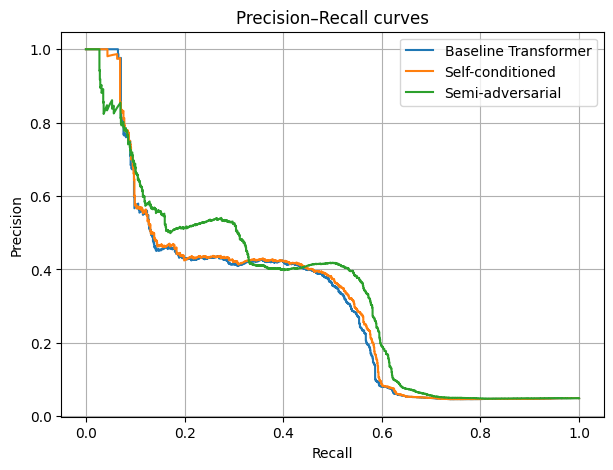

In [52]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

# Baseline
p_b, r_b, _ = precision_recall_curve(test_labels, test_errors_best)
plt.plot(r_b, p_b, label="Baseline Transformer")

# Self-conditioned
p_sc, r_sc, _ = precision_recall_curve(test_labels, test_errors_focus)
plt.plot(r_sc, p_sc, label="Self-conditioned")

# Semi-adversarial
p_sa, r_sa, _ = precision_recall_curve(test_labels, test_semi_focus)
plt.plot(r_sa, p_sa, label="Semi-adversarial")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curves")
plt.legend()
plt.grid()
plt.show()


# 8. Qualitative diagnostics with the Best Transformer (LN + Huber)

## 8.1 Loss curves: LSTM vs best Transformer

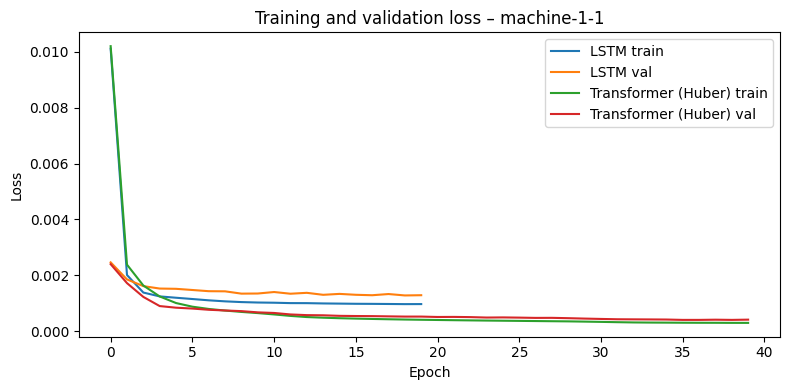

In [53]:
# ==== 8.1 Loss Curves for LSTM vs Best Transformer ====

if 'hist_lstm' in globals() and 'hist_best' in globals():
    plt.figure(figsize=(8,4))
    plt.plot(hist_lstm["train_loss"], label="LSTM train")
    plt.plot(hist_lstm["val_loss"],   label="LSTM val")
    plt.plot(hist_best["train_loss"], label="Transformer (Huber) train")
    plt.plot(hist_best["val_loss"],   label="Transformer (Huber) val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and validation loss – machine-1-1")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Missing hist_lstm or hist_best.")


## 8.2 Feature-level diagnosis with best Transformer

In [54]:
# ==== 8.2 Feature-level diagnosis with Best Transformer ====

if 'best_model' in globals():
    print("\n=== Feature-level diagnosis (Best Transformer) ===")
    feat_errors_train_best = compute_feature_level_errors(best_model, train_windows)
    feat_errors_test_best  = compute_feature_level_errors(best_model, test_windows)

    print("Feature-level error matrices:")
    print("  train:", feat_errors_train_best.shape)
    print("  test :", feat_errors_test_best.shape)

    feat_thresholds_best = choose_feature_thresholds(feat_errors_train_best, quantile=0.995)
    y_pred_feat_best     = compute_feature_level_predictions(feat_errors_test_best, feat_thresholds_best)

    # se vuoi collegarlo al detection time-level del best model:
    anomalous_times = np.where(y_pred_best == 1)[0]
    print(f"Number of anomalous timestamps (time-level): {len(anomalous_times)}")

    for t in anomalous_times[:5]:
        anomalous_features = np.where(y_pred_feat_best[t] == 1)[0]
        print(f"t = {t:5d} | anomalous features (indices) = {anomalous_features}")
else:
    print("Warning: 'best_model' not found – train it first.")



=== Feature-level diagnosis (Best Transformer) ===
Feature-level error matrices:
  train: (23693, 38)
  test : (23694, 38)
Number of anomalous timestamps (time-level): 942
t =   747 | anomalous features (indices) = [ 5  6  9 12 13]
t =  2120 | anomalous features (indices) = [ 0  5  6 13 27 31 35]
t =  2121 | anomalous features (indices) = [ 0  5  6 13 27 31 35]
t =  2122 | anomalous features (indices) = [ 0  5  6 13 27 31 35]
t =  2123 | anomalous features (indices) = [ 0  5  6 19 27 30 31 35]



=== Feature-level diagnosis (Best Transformer) ===
Feature-level error matrices:
  train: (23693, 38)
  test : (23694, 38)
Number of anomalous timestamps (time-level predictions): 942
t =   747 | anomalous features (indices) = [ 5  6  9 12 13]
t =  2120 | anomalous features (indices) = [ 0  5  6 13 27 31 35]
t =  2121 | anomalous features (indices) = [ 0  5  6 13 27 31 35]
t =  2122 | anomalous features (indices) = [ 0  5  6 13 27 31 35]
t =  2123 | anomalous features (indices) = [ 0  5  6 19 27 30 31 35]


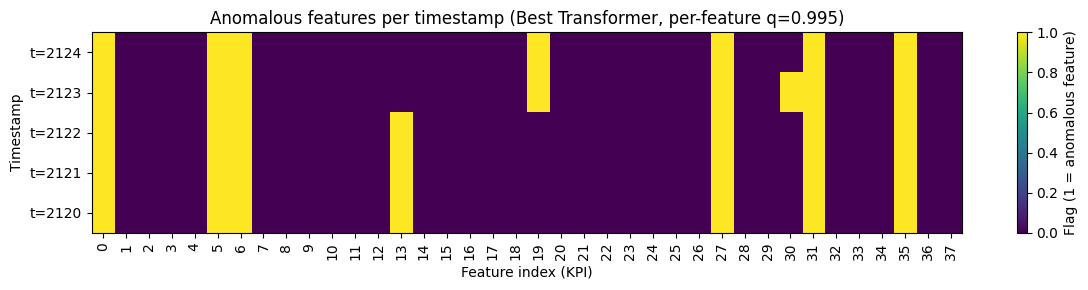

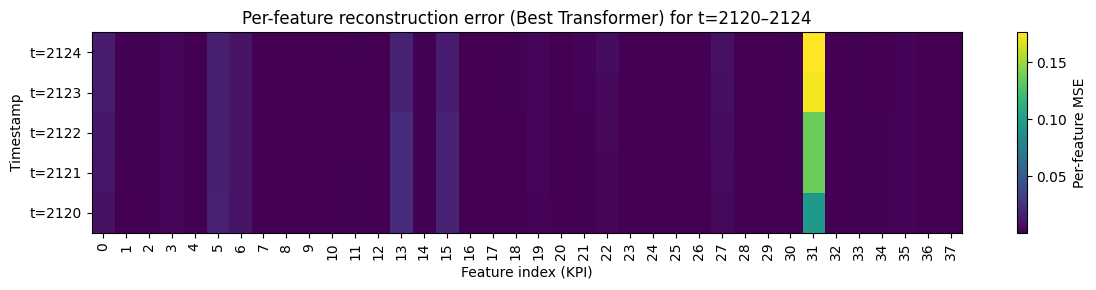

In [55]:
# ==== 8.2 Feature-level diagnosis with Best Transformer ====
# Goal:
# 1) Compute per-feature reconstruction error (MSE) for each timestamp.
# 2) Define a feature-specific threshold as the 99.5th percentile of TRAIN errors.
# 3) Flag a feature as anomalous at time t if its error exceeds its feature threshold.
# 4) Visualize which features are anomalous for a selected time interval (e.g., t=2120..2124).

import numpy as np
import matplotlib.pyplot as plt

# ---- Safety checks ----
required_vars = ["best_model", "train_windows", "test_windows", "test_labels"]
missing = [v for v in required_vars if v not in globals()]
if missing:
    print(f"Missing variables: {missing}. Run preprocessing / train the best model first.")
else:
    # ---- 1) Compute feature-level errors: shape (T, D) ----
    feat_errors_train_best = compute_feature_level_errors(best_model, train_windows)
    feat_errors_test_best  = compute_feature_level_errors(best_model, test_windows)

    print("\n=== Feature-level diagnosis (Best Transformer) ===")
    print("Feature-level error matrices:")
    print("  train:", feat_errors_train_best.shape)
    print("  test :", feat_errors_test_best.shape)

    # ---- 2) Feature-specific thresholds (99.5th percentile on TRAIN) ----
    quantile = 0.995
    feat_thresholds_best = choose_feature_thresholds(feat_errors_train_best, quantile=quantile)

    # ---- 3) Binary predictions per (time, feature): shape (T, D) ----
    y_pred_feat_best = compute_feature_level_predictions(feat_errors_test_best, feat_thresholds_best)

    # ---- 4) Option A: link to time-level detection if available ----
    # If you already computed y_pred_best (time-level predictions), use it.
    # Otherwise, you can use ground-truth labels as a proxy for "times of interest".
    if "y_pred_best" in globals():
        anomalous_times = np.where(y_pred_best == 1)[0]
        print(f"Number of anomalous timestamps (time-level predictions): {len(anomalous_times)}")
    else:
        anomalous_times = np.where(test_labels == 1)[0]
        print(f"y_pred_best not found -> using ground-truth anomalies as times of interest: {len(anomalous_times)}")

    # ---- Print a few example timestamps (like your output) ----
    for t in anomalous_times[:5]:
        anomalous_features = np.where(y_pred_feat_best[t] == 1)[0]
        print(f"t = {t:5d} | anomalous features (indices) = {anomalous_features}")

    # ---- 5) FIGURE: show anomalous features for timestamps 2120–2124 ----
    # This is the "correct image" to match your narrative in the report.
    times_to_show = np.array([2120, 2121, 2122, 2123, 2124])
    times_to_show = times_to_show[times_to_show < y_pred_feat_best.shape[0]]  # bounds check

    # Binary matrix (rows=time, cols=feature)
    binary_flags = y_pred_feat_best[times_to_show, :]  # shape (len(times), D)

    plt.figure(figsize=(12, 3))
    plt.imshow(binary_flags, aspect="auto", interpolation="nearest", origin="lower")
    plt.colorbar(label="Flag (1 = anomalous feature)")
    plt.yticks(np.arange(len(times_to_show)), [f"t={t}" for t in times_to_show])
    plt.xticks(np.arange(binary_flags.shape[1]), np.arange(binary_flags.shape[1]), rotation=90)
    plt.xlabel("Feature index (KPI)")
    plt.ylabel("Timestamp")
    plt.title(f"Anomalous features per timestamp (Best Transformer, per-feature q={quantile})")
    plt.tight_layout()
    plt.show()

    # ---- 6) OPTIONAL: show per-feature MSE values for the same timestamps (not just flags) ----
    # This helps justify why Feature 31 is "high" (quantitative support).
    mse_slice = feat_errors_test_best[times_to_show, :]  # (len(times), D)

    plt.figure(figsize=(12, 3))
    plt.imshow(mse_slice, aspect="auto", interpolation="nearest", origin="lower")
    plt.colorbar(label="Per-feature MSE")
    plt.yticks(np.arange(len(times_to_show)), [f"t={t}" for t in times_to_show])
    plt.xticks(np.arange(mse_slice.shape[1]), np.arange(mse_slice.shape[1]), rotation=90)
    plt.xlabel("Feature index (KPI)")
    plt.ylabel("Timestamp")
    plt.title("Per-feature reconstruction error (Best Transformer) for t=2120–2124")
    plt.tight_layout()
    plt.show()


## 8.3 Error scale and outlier filtering (Best Transformer)

We first inspect the raw score range and remove numerically unstable outliers
before plotting the error distributions.


In [56]:
# 1) Take the train and test reconstruction errors of the BEST Transformer
train_scores = np.asarray(train_errors_best)
test_scores  = np.asarray(test_errors_best)

# 2) Print basic info: size and value range
print("Train scores shape:", train_scores.shape)
print("Test  scores shape:", test_scores.shape)
print("Train scores  min / max:", float(train_scores.min()), float(train_scores.max()))
print("Test  scores  min / max:", float(test_scores.min()),  float(test_scores.max()))

# 3) Build a mask to remove non-finite or extremely large scores (>= 1e3)
mask_good = np.isfinite(test_scores) & (test_scores < 1e3)
print("Non-finite values:", np.sum(~np.isfinite(test_scores)))
print("Extremely large values:", np.sum(test_scores >= 1e3))

# 4) Apply the mask to get a cleaned version of the test scores
test_scores_filtered = test_scores[mask_good]
print("Filtered test scores:", test_scores_filtered.shape)
print("Filtered min/max:", test_scores_filtered.min(), test_scores_filtered.max())

Train scores shape: (23693,)
Test  scores shape: (23694,)
Train scores  min / max: 0.00014571723295375705 0.016540104523301125
Test  scores  min / max: 0.000311967043671757 0.2852705121040344
Non-finite values: 0
Extremely large values: 0
Filtered test scores: (23694,)
Filtered min/max: 0.00031196704 0.2852705


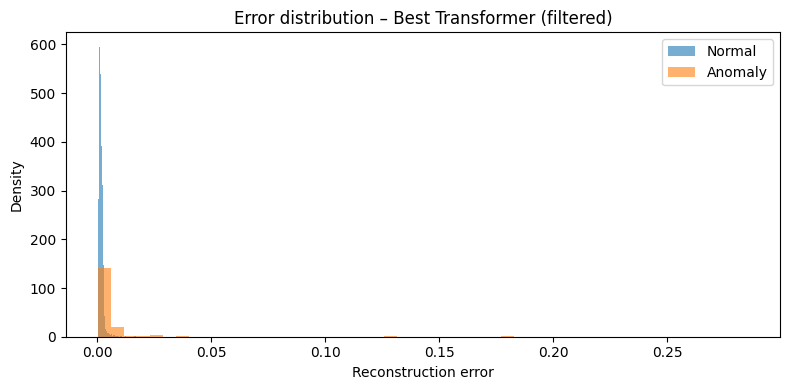

In [57]:
# Use filtered scores and corresponding labels
scores_good = test_scores_filtered
labels_good = test_labels[mask_good]

normal_scores  = scores_good[labels_good == 0]
anomaly_scores = scores_good[labels_good == 1]

plt.figure(figsize=(8,4))
plt.hist(normal_scores,  bins=50, density=True, alpha=0.6, label="Normal")
plt.hist(anomaly_scores, bins=50, density=True, alpha=0.6, label="Anomaly")
plt.xlabel("Reconstruction error")
plt.ylabel("Density")
plt.title("Error distribution – Best Transformer (filtered)")
plt.legend()
plt.tight_layout()
plt.show()

## 8.4 Error distribution – Best Transformer

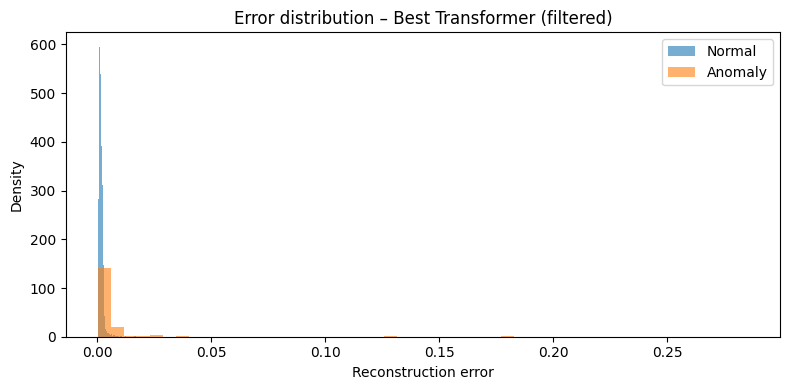

In [58]:
# ==== 8.4 Error distribution: normal vs anomaly ====

test_scores = np.asarray(test_errors_best)

mask_good = np.isfinite(test_scores) & (test_scores < 1e3)
scores_good = test_scores[mask_good]
labels_good = test_labels[mask_good]

normal_scores  = scores_good[labels_good == 0]
anomaly_scores = scores_good[labels_good == 1]

plt.figure(figsize=(8,4))
plt.hist(normal_scores,  bins=50, density=True, alpha=0.6, label="Normal")
plt.hist(anomaly_scores, bins=50, density=True, alpha=0.6, label="Anomaly")
plt.xlabel("Reconstruction error")
plt.ylabel("Density")
plt.title("Error distribution – Best Transformer (filtered)")
plt.legend()
plt.tight_layout()
plt.show()

## 8.5 Raw signal + reconstruction error (Best Transformer, around a true anomaly)

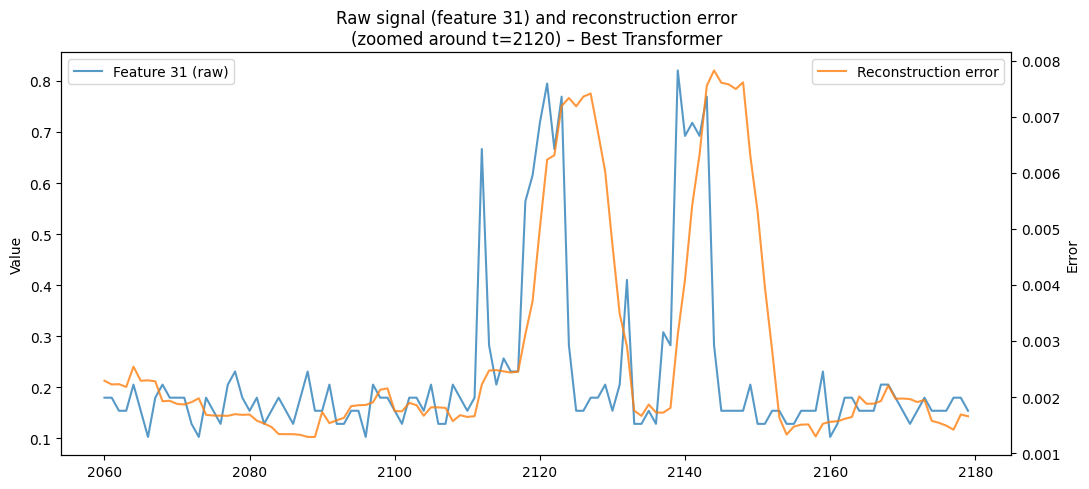

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# === Choose one true anomalous time ===
t_center = 2120      # from your feature-level diagnosis
half_window = 60

t0 = max(0, t_center - half_window)
t1 = min(len(test_labels), t_center + half_window)

# === Choose a strongly anomalous feature ===
FEATURE = 31   # the feature with highest MSE around the anomaly

plt.figure(figsize=(11, 5))

# --- 1) Raw signal ---
ax1 = plt.gca()
ax1.plot(
    np.arange(t0, t1),
    test_data[t0:t1, FEATURE],
    label=f"Feature {FEATURE} (raw)",
    alpha=0.75
)
ax1.set_ylabel("Value")

# --- 2) Reconstruction error on second y-axis ---
ax2 = ax1.twinx()
ax2.plot(
    np.arange(t0, t1),
    test_errors_best[t0:t1],
    label="Reconstruction error",
    color="tab:orange",
    alpha=0.8
)
ax2.set_ylabel("Error")

# --- 3) Mark ground-truth anomalies ---
anom_idx = np.where(test_labels[t0:t1] == 1)[0]
if anom_idx.size > 0:
    ax2.scatter(
        t0 + anom_idx,
        test_errors_best[t0:t1][anom_idx],
        color="red",
        marker="x",
        label="Anomaly"
    )

plt.title(f"Raw signal (feature {FEATURE}) and reconstruction error\n(zoomed around t={t_center}) – Best Transformer")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()


*To show anomaly*

In [60]:
import numpy as np

# 1) All true anomalies
true_anomalies = np.where(test_labels == 1)[0]

# 2) Filter only those with high reconstruction error
#    We take the top 5 highest-error true anomalies
error_values = test_errors_best[true_anomalies]
top_idx = np.argsort(error_values)[-5:]   # highest 5 errors
candidate_times = true_anomalies[top_idx]

print("Candidate anomaly timestamps (true anomaly + high error):", candidate_times)

# 3) Choose the best one
t_center = int(candidate_times[-1])   # pick the highest-error anomaly
print("Chosen t_center =", t_center)


Candidate anomaly timestamps (true anomaly + high error): [22921 22922 22923 22925 22924]
Chosen t_center = 22924


## 8.6 Feature-wise reconstruction error heatmap (Best Transformer, same zoom)

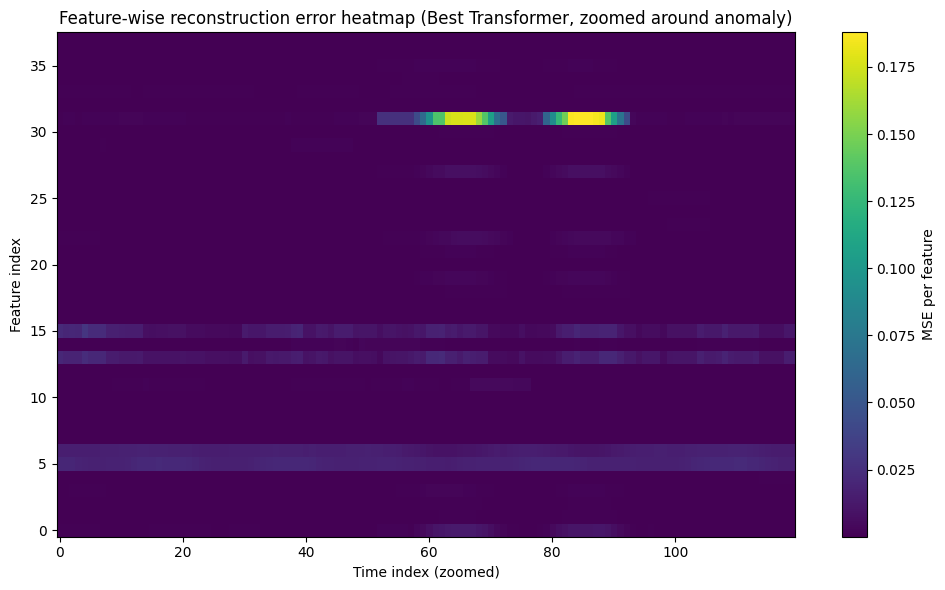

In [61]:
import matplotlib.pyplot as plt

# Use the same interval [t0, t1] as in the raw+error plot
window = slice(t0, t1)

# feat_errors_test_best: feature-level MSE for the Best Transformer
subset_best = feat_errors_test_best[window, :].T  # (D, time)

plt.figure(figsize=(10, 6))
plt.imshow(subset_best, aspect='auto', origin='lower')
plt.colorbar(label='MSE per feature')
plt.xlabel("Time index (zoomed)")
plt.ylabel("Feature index")
plt.title("Feature-wise reconstruction error heatmap (Best Transformer, zoomed around anomaly)")
plt.tight_layout()
plt.show()


In [62]:
# 1) Take the train and test reconstruction errors of the BEST Transformer
train_scores = np.asarray(train_errors_best)
test_scores  = np.asarray(test_errors_best)

# 2) Print basic info: size and value range
print("Train scores shape:", train_scores.shape)
print("Test  scores shape:", test_scores.shape)
print("Train scores  min / max:", float(train_scores.min()), float(train_scores.max()))
print("Test  scores  min / max:", float(test_scores.min()),  float(test_scores.max()))

# 3) Build a mask to remove non-finite or extremely large scores (>= 1e3)
mask_good = np.isfinite(test_scores) & (test_scores < 1e3)
print("Non-finite values:", np.sum(~np.isfinite(test_scores)))
print("Extremely large values:", np.sum(test_scores >= 1e3))

# 4) Apply the mask to get a cleaned version of the test scores
test_scores_filtered = test_scores[mask_good]
print("Filtered test scores:", test_scores_filtered.shape)
print("Filtered min/max:", test_scores_filtered.min(), test_scores_filtered.max())

Train scores shape: (23693,)
Test  scores shape: (23694,)
Train scores  min / max: 0.00014571723295375705 0.016540104523301125
Test  scores  min / max: 0.000311967043671757 0.2852705121040344
Non-finite values: 0
Extremely large values: 0
Filtered test scores: (23694,)
Filtered min/max: 0.00031196704 0.2852705


# 12. Appendix
This appendix collects supplementary material for reproducibility:
hyperparameters, architecture summaries, and raw diagnostic plots generated
throughout the notebook.

---

## 12.1 Full Hyperparameters

### LSTM Autoencoder
- **Input dimension**: 38  
- **Hidden dimension**: 64  
- **Latent dimension**: 32  
- **Num.\ layers**: 1  
- **Learning rate**: 1e-3  
- **Batch size**: 128  
- **Epochs**: 20  
- **Optimizer**: Adam  
- **Loss**: MSE reconstruction  

### Transformer AE (LN + Huber)
- **d\_model**: 64  
- **num\_heads**: 4  
- **num\_layers**: 1 encoder + 1 decoder  
- **Feedforward dimension**: 128  
- **Dropout**: 0.1  
- **LayerNorm position**: pre-norm (`norm_first=True`)  
- **Learning rate**: 1e-3  
- **Batch size**: 128  
- **Epochs**: 20 or 40  
- **Loss**: Huber (β=1.0)  
- **Optimizer**: Adam  

### Stabilised Transformer AE
(LayerNorm + Dropout + Huber + Sigmoid + Clipping)
- **d\_model**: 64  
- **num\_heads**: 4  
- **num\_layers**: 1 + 1  
- **Dropout**: 0.3  
- **Output activation**: Sigmoid  
- **Gradient clipping**: max\_norm = 1.0  
- **Learning rate**: 5e-4  
- **Loss**: SmoothL1Loss (Huber)  

### Semi-Adversarial Transformer (refinement)
- **Margin penalty weight** (`lambda_margin`): 0.5  
- **Margin threshold** (`margin`): 0.02  
- **Synthetic anomaly settings**:  
  - `spike_features` = 3  
  - `spike_scale` = 5.0  
- **Purpose**: increase separation between normal and anomalous windows during training  

### Window Sizes Tried
- **K = 10, 30, 50**
- K acts as a maximum autoregressive order.  
- K=30 showed strongest performance for MSE-based Transformers.  
- K=10 is sufficient for Huber-based (more robust) variants.